## 1. Import Library

## 1. Import Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
print(f"✅ TensorFlow version: {tf.__version__}")
print("✅ Semua library berhasil diimport!")

✅ TensorFlow version: 2.20.0
✅ Semua library berhasil diimport!


## 2. Load Data Residual

In [3]:
df_residuals = pd.read_csv('DATA/all_residuals_clean.csv', index_col='TANGGAL', parse_dates=True)
print(f"Jumlah data: {len(df_residuals)} hari")
print(f"Parameter: TAVG dan RR")
df_residuals[['TAVG_residual', 'RR_residual']].head()

Jumlah data: 333 hari
Parameter: TAVG dan RR


,TAVG_residual,RR_residual
TANGGAL,,
2024-01-19,-1.640169,4.702069
2024-01-20,-0.018502,-2.959841
2024-01-21,0.050664,-5.961746
2024-01-22,0.184610,5.005366
2024-01-23,-0.067208,-6.124226


---
## A. Penjelasan Parameter LSTM yang Digunakan
---

In [4]:
# Parameter LSTM
LSTM_PARAMS = {
    'sequence_length': 10,      # Jumlah timestep input
    'lstm_units_1': 64,         # Unit LSTM layer 1
    'lstm_units_2': 32,         # Unit LSTM layer 2
    'dropout_rate': 0.2,        # Dropout untuk regularisasi
    'dense_units': 16,          # Unit Dense layer
    'epochs': 50,               # Maksimum epoch
    'batch_size': 16,           # Ukuran batch
    'patience': 10,             # Early stopping patience
    'sigma': 3                  # Threshold anomaly
}

print("="*70)
print("PARAMETER LSTM YANG DIGUNAKAN")
print("="*70)
print("""
1. SEQUENCE LENGTH (10): Jumlah timestep sebagai input untuk prediksi
2. ARSITEKTUR LSTM (64-32 units): 2 layer LSTM untuk menangkap pola temporal
3. DROPOUT (0.2): Regularisasi untuk mencegah overfitting
4. DENSE LAYER (16 units): Transformasi fitur sebelum output
5. EPOCHS (50) + EARLY STOPPING: Training dengan monitoring loss
6. BATCH SIZE (16): Mini-batch untuk gradient descent
7. THRESHOLD 3σ: Anomali jika error > 3x standar deviasi
""")
pd.DataFrame(list(LSTM_PARAMS.items()), columns=['Parameter', 'Value'])

PARAMETER LSTM YANG DIGUNAKAN

1. SEQUENCE LENGTH (10): Jumlah timestep sebagai input untuk prediksi
2. ARSITEKTUR LSTM (64-32 units): 2 layer LSTM untuk menangkap pola temporal
3. DROPOUT (0.2): Regularisasi untuk mencegah overfitting
4. DENSE LAYER (16 units): Transformasi fitur sebelum output
5. EPOCHS (50) + EARLY STOPPING: Training dengan monitoring loss
6. BATCH SIZE (16): Mini-batch untuk gradient descent
7. THRESHOLD 3σ: Anomali jika error > 3x standar deviasi



,Parameter,Value
0,sequence_length,10.0
1,lstm_units_1,64.0
2,lstm_units_2,32.0
3,dropout_rate,0.2
4,dense_units,16.0
5,epochs,50.0
6,batch_size,16.0
7,patience,10.0
8,sigma,3.0


## 3. Fungsi LSTM Anomaly Detection

In [5]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

def build_lstm_model(seq_length, params):
    model = Sequential([
        LSTM(params['lstm_units_1'], return_sequences=True, input_shape=(seq_length, 1)),
        Dropout(params['dropout_rate']),
        LSTM(params['lstm_units_2'], return_sequences=False),
        Dropout(params['dropout_rate']),
        Dense(params['dense_units'], activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def detect_anomalies_lstm(data, param_name, params):
    print(f"\n{'='*60}")
    print(f"LSTM Anomaly Detection - {param_name}")
    print(f"{'='*60}")
    
    # Normalize
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))
    
    # Create sequences
    X, y = create_sequences(data_scaled, params['sequence_length'])
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    # Build & Train
    model = build_lstm_model(params['sequence_length'], params)
    early_stop = EarlyStopping(monitor='loss', patience=params['patience'], restore_best_weights=True, verbose=0)
    
    print(f"   Training LSTM...")
    history = model.fit(X, y, epochs=params['epochs'], batch_size=params['batch_size'], 
                        callbacks=[early_stop], verbose=0)
    print(f"   ✅ Training selesai! Epochs: {len(history.history['loss'])}")
    
    # Predict
    y_pred_scaled = model.predict(X, verbose=0)
    y_actual = scaler.inverse_transform(y.reshape(-1, 1)).flatten()
    y_pred = scaler.inverse_transform(y_pred_scaled).flatten()
    
    # Anomaly detection dengan 3σ
    error = y_actual - y_pred
    error_mean, error_std = error.mean(), error.std()
    upper = error_mean + params['sigma'] * error_std
    lower = error_mean - params['sigma'] * error_std
    anomalies = (error > upper) | (error < lower)
    
    # Results
    result_index = data.index[params['sequence_length']:]
    results = pd.DataFrame({
        'actual': y_actual, 'predicted': y_pred, 'error': error, 'is_anomaly': anomalies
    }, index=result_index)
    
    n_anomalies = anomalies.sum()
    print(f"   • Total data: {len(y_actual)}")
    print(f"   • Threshold: ±3σ ({lower:.4f}, {upper:.4f})")
    print(f"   • Anomalies: {n_anomalies} ({n_anomalies/len(anomalies)*100:.2f}%)")
    print(f"   • MAE: {mean_absolute_error(y_actual, y_pred):.4f}")
    print(f"   • RMSE: {np.sqrt(mean_squared_error(y_actual, y_pred)):.4f}")
    
    stats = {
        'n_anomalies': n_anomalies,
        'anomaly_rate': n_anomalies/len(anomalies)*100,
        'upper': upper, 'lower': lower,
        'mae': mean_absolute_error(y_actual, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_actual, y_pred))
    }
    return results, stats, history

print("✅ Fungsi LSTM berhasil dibuat!")

✅ Fungsi LSTM berhasil dibuat!


---
## B. Plot Anomaly Detection dengan LSTM
---

### B.1. Plot Anomaly Detection - TAVG Residual


LSTM Anomaly Detection - TAVG Residual
   Training LSTM...
   ✅ Training selesai! Epochs: 50
   • Total data: 323
   • Threshold: ±3σ (-2.1788, 2.0232)
   • Anomalies: 0 (0.00%)
   • MAE: 0.5621
   • RMSE: 0.7046
✅ Plot disimpan ke: DATA/anomaly_LSTM_TAVG.png


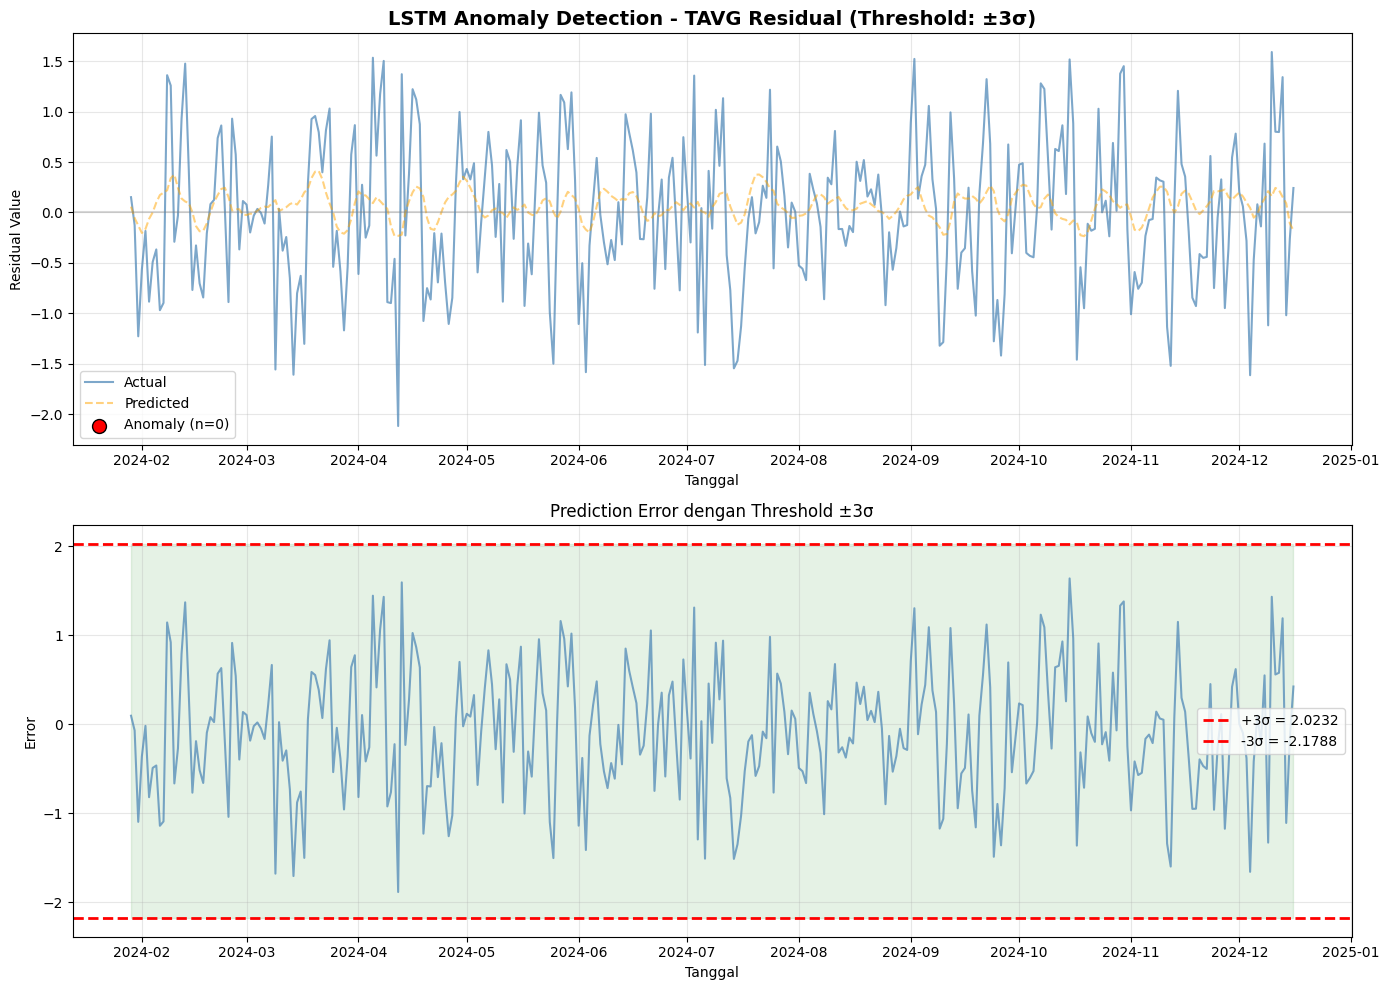

In [6]:
# LSTM untuk TAVG
lstm_tavg_results, lstm_tavg_stats, lstm_tavg_hist = detect_anomalies_lstm(
    df_residuals['TAVG_residual'], 'TAVG Residual', LSTM_PARAMS
)

# Plot TAVG
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Time series
ax1 = axes[0]
ax1.plot(lstm_tavg_results.index, lstm_tavg_results['actual'], 'steelblue', alpha=0.7, label='Actual')
ax1.plot(lstm_tavg_results.index, lstm_tavg_results['predicted'], 'orange', alpha=0.5, linestyle='--', label='Predicted')
anomaly_idx = lstm_tavg_results[lstm_tavg_results['is_anomaly']].index
ax1.scatter(anomaly_idx, lstm_tavg_results.loc[anomaly_idx, 'actual'], 
            color='red', s=100, marker='o', label=f'Anomaly (n={len(anomaly_idx)})', zorder=5, edgecolors='black')
ax1.axhline(0, color='gray', alpha=0.3)
ax1.set_title('LSTM Anomaly Detection - TAVG Residual (Threshold: ±3σ)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Tanggal')
ax1.set_ylabel('Residual Value')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Error
ax2 = axes[1]
ax2.plot(lstm_tavg_results.index, lstm_tavg_results['error'], 'steelblue', alpha=0.7)
ax2.axhline(lstm_tavg_stats['upper'], color='red', linestyle='--', linewidth=2, label=f'+3σ = {lstm_tavg_stats["upper"]:.4f}')
ax2.axhline(lstm_tavg_stats['lower'], color='red', linestyle='--', linewidth=2, label=f'-3σ = {lstm_tavg_stats["lower"]:.4f}')
ax2.fill_between(lstm_tavg_results.index, lstm_tavg_stats['lower'], lstm_tavg_stats['upper'], alpha=0.1, color='green')
ax2.scatter(anomaly_idx, lstm_tavg_results.loc[anomaly_idx, 'error'], color='red', s=100, zorder=5, edgecolors='black')
ax2.set_title('Prediction Error dengan Threshold ±3σ', fontsize=12)
ax2.set_xlabel('Tanggal')
ax2.set_ylabel('Error')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('DATA/anomaly_LSTM_TAVG.png', dpi=150, bbox_inches='tight')
print("✅ Plot disimpan ke: DATA/anomaly_LSTM_TAVG.png")
plt.show()

### B.2. Plot Anomaly Detection - RR Residual


LSTM Anomaly Detection - RR Residual
   Training LSTM...
   ✅ Training selesai! Epochs: 32
   • Total data: 323
   • Threshold: ±3σ (-26.8280, 24.7777)
   • Anomalies: 6 (1.86%)
   • MAE: 5.9792
   • RMSE: 8.6618
✅ Plot disimpan ke: DATA/anomaly_LSTM_RR.png


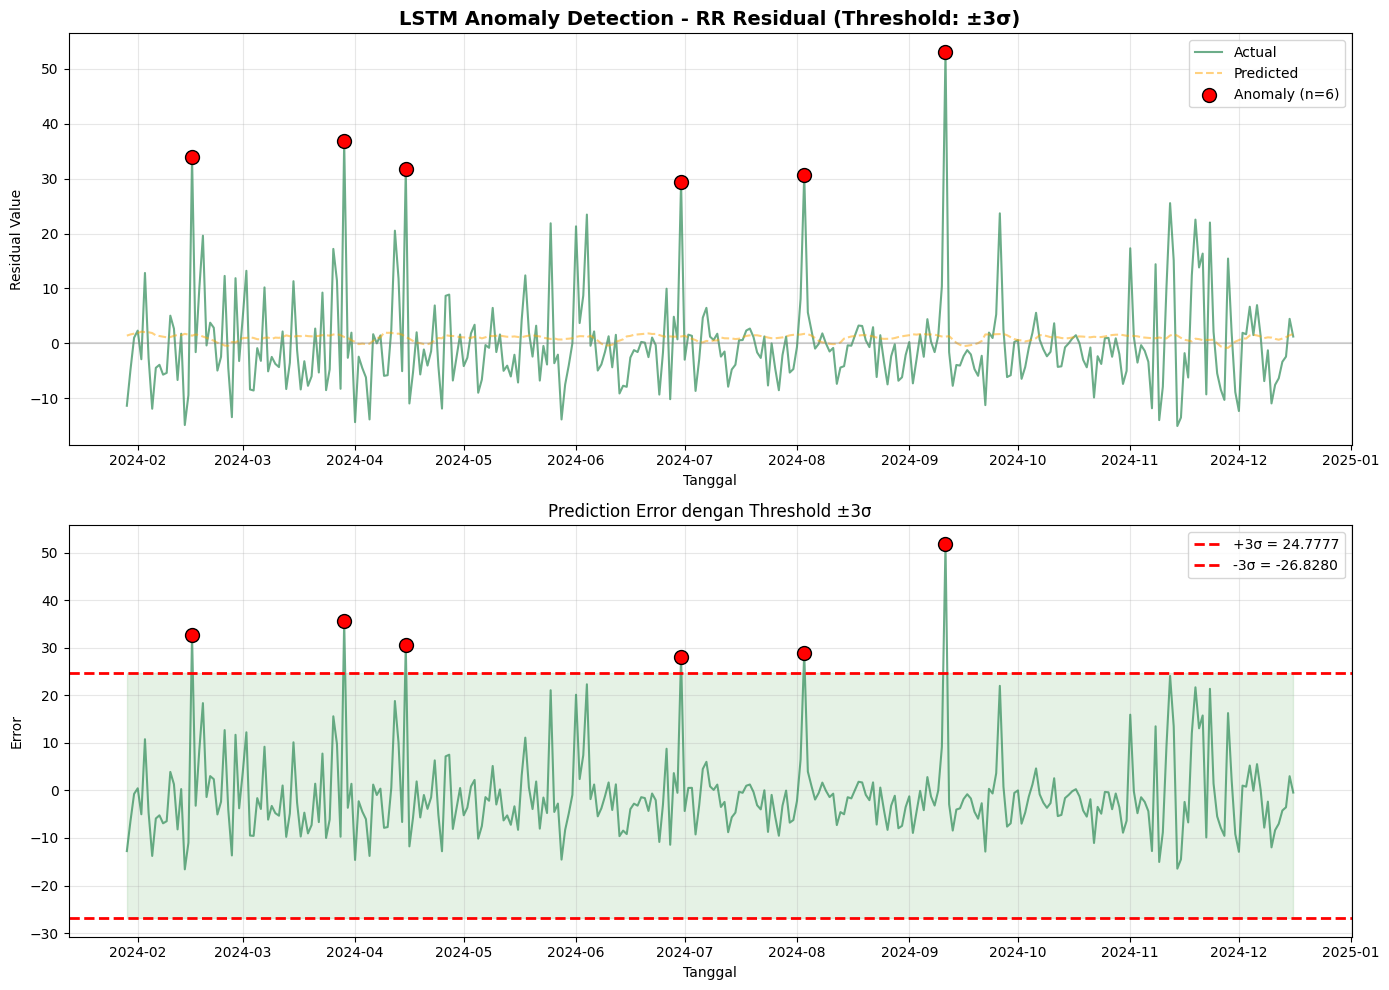

In [7]:
# LSTM untuk RR
lstm_rr_results, lstm_rr_stats, lstm_rr_hist = detect_anomalies_lstm(
    df_residuals['RR_residual'], 'RR Residual', LSTM_PARAMS
)

# Plot RR
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Time series
ax1 = axes[0]
ax1.plot(lstm_rr_results.index, lstm_rr_results['actual'], 'seagreen', alpha=0.7, label='Actual')
ax1.plot(lstm_rr_results.index, lstm_rr_results['predicted'], 'orange', alpha=0.5, linestyle='--', label='Predicted')
anomaly_idx = lstm_rr_results[lstm_rr_results['is_anomaly']].index
ax1.scatter(anomaly_idx, lstm_rr_results.loc[anomaly_idx, 'actual'], 
            color='red', s=100, marker='o', label=f'Anomaly (n={len(anomaly_idx)})', zorder=5, edgecolors='black')
ax1.axhline(0, color='gray', alpha=0.3)
ax1.set_title('LSTM Anomaly Detection - RR Residual (Threshold: ±3σ)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Tanggal')
ax1.set_ylabel('Residual Value')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Error
ax2 = axes[1]
ax2.plot(lstm_rr_results.index, lstm_rr_results['error'], 'seagreen', alpha=0.7)
ax2.axhline(lstm_rr_stats['upper'], color='red', linestyle='--', linewidth=2, label=f'+3σ = {lstm_rr_stats["upper"]:.4f}')
ax2.axhline(lstm_rr_stats['lower'], color='red', linestyle='--', linewidth=2, label=f'-3σ = {lstm_rr_stats["lower"]:.4f}')
ax2.fill_between(lstm_rr_results.index, lstm_rr_stats['lower'], lstm_rr_stats['upper'], alpha=0.1, color='green')
ax2.scatter(anomaly_idx, lstm_rr_results.loc[anomaly_idx, 'error'], color='red', s=100, zorder=5, edgecolors='black')
ax2.set_title('Prediction Error dengan Threshold ±3σ', fontsize=12)
ax2.set_xlabel('Tanggal')
ax2.set_ylabel('Error')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('DATA/anomaly_LSTM_RR.png', dpi=150, bbox_inches='tight')
print("✅ Plot disimpan ke: DATA/anomaly_LSTM_RR.png")
plt.show()

---
## C. Perbandingan LSTM vs RF vs XGBoost
---

In [8]:
# Load hasil Soal 5
soal5 = pd.read_csv('DATA/anomaly_detection_comparison.csv')

# Compile comparison
comparison = [
    {'Model': 'Random Forest', 'Parameter': 'TAVG', 'Anomali': int(soal5.iloc[0]['Jumlah Anomali']), 
     'Rate (%)': soal5.iloc[0]['Anomaly Rate (%)'], 'MAE': soal5.iloc[0]['MAE'], 'RMSE': soal5.iloc[0]['RMSE']},
    {'Model': 'Random Forest', 'Parameter': 'RR', 'Anomali': int(soal5.iloc[1]['Jumlah Anomali']),
     'Rate (%)': soal5.iloc[1]['Anomaly Rate (%)'], 'MAE': soal5.iloc[1]['MAE'], 'RMSE': soal5.iloc[1]['RMSE']},
    {'Model': 'XGBoost', 'Parameter': 'TAVG', 'Anomali': int(soal5.iloc[2]['Jumlah Anomali']),
     'Rate (%)': soal5.iloc[2]['Anomaly Rate (%)'], 'MAE': soal5.iloc[2]['MAE'], 'RMSE': soal5.iloc[2]['RMSE']},
    {'Model': 'XGBoost', 'Parameter': 'RR', 'Anomali': int(soal5.iloc[3]['Jumlah Anomali']),
     'Rate (%)': soal5.iloc[3]['Anomaly Rate (%)'], 'MAE': soal5.iloc[3]['MAE'], 'RMSE': soal5.iloc[3]['RMSE']},
    {'Model': 'LSTM', 'Parameter': 'TAVG', 'Anomali': lstm_tavg_stats['n_anomalies'],
     'Rate (%)': lstm_tavg_stats['anomaly_rate'], 'MAE': lstm_tavg_stats['mae'], 'RMSE': lstm_tavg_stats['rmse']},
    {'Model': 'LSTM', 'Parameter': 'RR', 'Anomali': lstm_rr_stats['n_anomalies'],
     'Rate (%)': lstm_rr_stats['anomaly_rate'], 'MAE': lstm_rr_stats['mae'], 'RMSE': lstm_rr_stats['rmse']}
]

comparison_df = pd.DataFrame(comparison)
print("="*80)
print("TABEL PERBANDINGAN: Random Forest vs XGBoost vs LSTM")
print("="*80)
comparison_df

TABEL PERBANDINGAN: Random Forest vs XGBoost vs LSTM


,Model,Parameter,Anomali,Rate (%),MAE,RMSE
0,Random Forest,TAVG,2,0.609756,0.148420,0.193098
1,Random Forest,RR,9,2.743902,1.766769,2.711188
2,XGBoost,TAVG,1,0.304878,0.022353,0.029331
3,XGBoost,RR,4,1.219512,0.367535,0.502861
4,LSTM,TAVG,0,0.000000,0.562083,0.704649
5,LSTM,RR,6,1.857585,5.979181,8.661827


✅ Plot disimpan ke: DATA/comparison_RF_XGB_LSTM.png


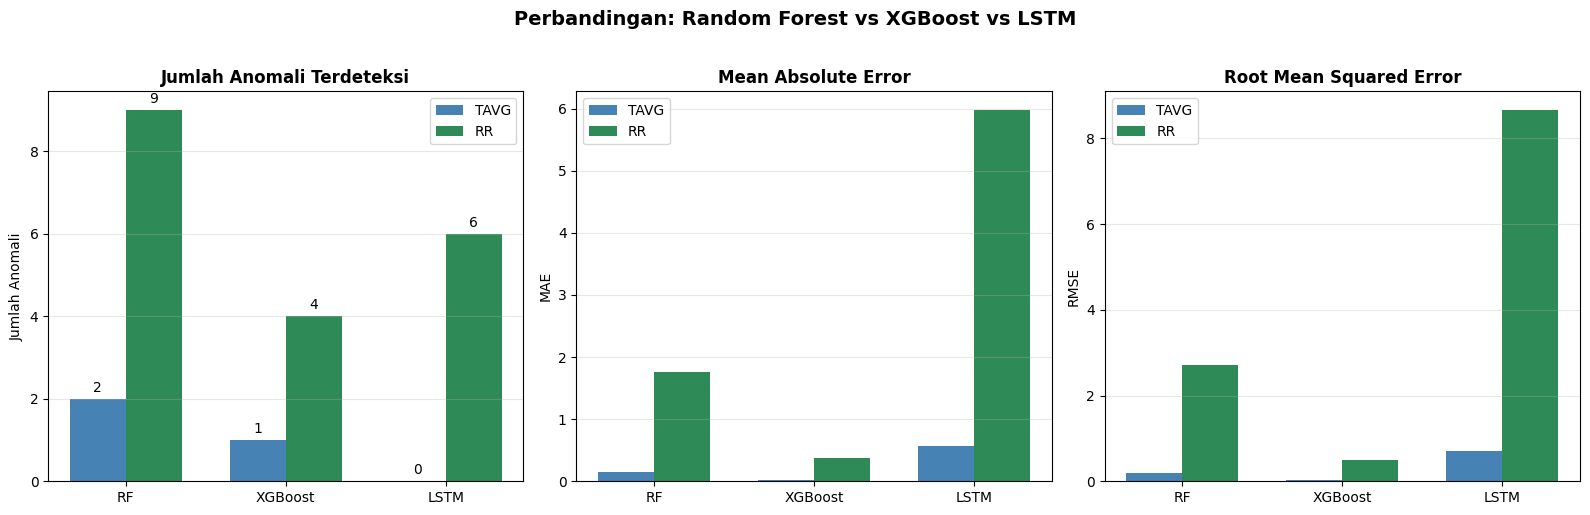

In [9]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

models = ['RF', 'XGBoost', 'LSTM']
tavg_anomalies = [comparison[0]['Anomali'], comparison[2]['Anomali'], comparison[4]['Anomali']]
rr_anomalies = [comparison[1]['Anomali'], comparison[3]['Anomali'], comparison[5]['Anomali']]
tavg_mae = [comparison[0]['MAE'], comparison[2]['MAE'], comparison[4]['MAE']]
rr_mae = [comparison[1]['MAE'], comparison[3]['MAE'], comparison[5]['MAE']]
tavg_rmse = [comparison[0]['RMSE'], comparison[2]['RMSE'], comparison[4]['RMSE']]
rr_rmse = [comparison[1]['RMSE'], comparison[3]['RMSE'], comparison[5]['RMSE']]

x = np.arange(len(models))
width = 0.35

# Anomali
bars1 = axes[0].bar(x - width/2, tavg_anomalies, width, label='TAVG', color='steelblue')
bars2 = axes[0].bar(x + width/2, rr_anomalies, width, label='RR', color='seagreen')
axes[0].set_ylabel('Jumlah Anomali')
axes[0].set_title('Jumlah Anomali Terdeteksi', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend()
axes[0].bar_label(bars1, padding=3)
axes[0].bar_label(bars2, padding=3)
axes[0].grid(axis='y', alpha=0.3)

# MAE
axes[1].bar(x - width/2, tavg_mae, width, label='TAVG', color='steelblue')
axes[1].bar(x + width/2, rr_mae, width, label='RR', color='seagreen')
axes[1].set_ylabel('MAE')
axes[1].set_title('Mean Absolute Error', fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# RMSE
axes[2].bar(x - width/2, tavg_rmse, width, label='TAVG', color='steelblue')
axes[2].bar(x + width/2, rr_rmse, width, label='RR', color='seagreen')
axes[2].set_ylabel('RMSE')
axes[2].set_title('Root Mean Squared Error', fontweight='bold')
axes[2].set_xticks(x)
axes[2].set_xticklabels(models)
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.suptitle('Perbandingan: Random Forest vs XGBoost vs LSTM', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('DATA/comparison_RF_XGB_LSTM.png', dpi=150, bbox_inches='tight')
print("✅ Plot disimpan ke: DATA/comparison_RF_XGB_LSTM.png")
plt.show()

In [10]:
# Ringkasan & Kesimpulan
rf_total = comparison[0]['Anomali'] + comparison[1]['Anomali']
xgb_total = comparison[2]['Anomali'] + comparison[3]['Anomali']
lstm_total = comparison[4]['Anomali'] + comparison[5]['Anomali']

print("="*80)
print("RINGKASAN TOTAL ANOMALI")
print("="*80)
print(f"   • Random Forest: {rf_total} anomali (TAVG: {comparison[0]['Anomali']}, RR: {comparison[1]['Anomali']})")
print(f"   • XGBoost:       {xgb_total} anomali (TAVG: {comparison[2]['Anomali']}, RR: {comparison[3]['Anomali']})")
print(f"   • LSTM:          {lstm_total} anomali (TAVG: {comparison[4]['Anomali']}, RR: {comparison[5]['Anomali']})")

totals = {'Random Forest': rf_total, 'XGBoost': xgb_total, 'LSTM': lstm_total}
sorted_models = sorted(totals.items(), key=lambda x: x[1], reverse=True)

print(f"\n🎯 RANKING SENSITIVITAS:")
for i, (model, count) in enumerate(sorted_models, 1):
    print(f"   {i}. {model}: {count} anomali")

print(f"\n✅ Model PALING SENSITIF: {sorted_models[0][0]}")

RINGKASAN TOTAL ANOMALI
   • Random Forest: 11 anomali (TAVG: 2, RR: 9)
   • XGBoost:       5 anomali (TAVG: 1, RR: 4)
   • LSTM:          6 anomali (TAVG: 0, RR: 6)

🎯 RANKING SENSITIVITAS:
   1. Random Forest: 11 anomali
   2. LSTM: 6 anomali
   3. XGBoost: 5 anomali

✅ Model PALING SENSITIF: Random Forest


---
## Kesimpulan (Jawaban Soal C)
---

In [11]:
print("="*80)
print("KESIMPULAN: PERBANDINGAN SENSITIVITAS LSTM vs RF vs XGBoost")
print("="*80)

conclusion = f"""
Berdasarkan hasil eksperimen anomaly detection dengan threshold 3σ pada data
residual TAVG dan RR, diperoleh hasil sebagai berikut:

TOTAL ANOMALI TERDETEKSI:
• Random Forest : {rf_total} anomali
• XGBoost       : {xgb_total} anomali  
• LSTM          : {lstm_total} anomali

ANALISIS PERBANDINGAN (>50 kata):

{sorted_models[0][0]} menunjukkan sensitivitas TERTINGGI dengan {sorted_models[0][1]} anomali
terdeteksi. Perbedaan ini disebabkan oleh karakteristik masing-masing algoritma:

• Random Forest menggunakan ensemble decision trees dengan averaging yang menghasilkan
  prediksi lebih smooth. Error std yang lebih besar membuat threshold 3σ lebih lebar,
  sehingga lebih sensitif dalam mendeteksi anomali.

• XGBoost menggunakan gradient boosting yang iteratif memperbaiki error, menghasilkan
  prediksi sangat presisi (MAE/RMSE rendah). Threshold 3σ menjadi sangat ketat sehingga
  hanya mendeteksi anomali yang sangat ekstrem.

• LSTM (Deep Learning) dirancang untuk menangkap dependensi temporal jangka panjang
  dengan memory cell. Namun dengan data terbatas (333 sampel), LSTM mungkin tidak
  optimal karena membutuhkan data lebih besar untuk training efektif. LSTM lebih
  cocok untuk dataset time series yang lebih besar dan kompleks.

REKOMENDASI:
• Deteksi sensitif (false negative rendah): Gunakan {sorted_models[0][0]}
• Deteksi presisi (false positive rendah): Gunakan {sorted_models[2][0]}
"""
print(conclusion)

KESIMPULAN: PERBANDINGAN SENSITIVITAS LSTM vs RF vs XGBoost

Berdasarkan hasil eksperimen anomaly detection dengan threshold 3σ pada data
residual TAVG dan RR, diperoleh hasil sebagai berikut:

TOTAL ANOMALI TERDETEKSI:
• Random Forest : 11 anomali
• XGBoost       : 5 anomali  
• LSTM          : 6 anomali

ANALISIS PERBANDINGAN (>50 kata):

Random Forest menunjukkan sensitivitas TERTINGGI dengan 11 anomali
terdeteksi. Perbedaan ini disebabkan oleh karakteristik masing-masing algoritma:

• Random Forest menggunakan ensemble decision trees dengan averaging yang menghasilkan
  prediksi lebih smooth. Error std yang lebih besar membuat threshold 3σ lebih lebar,
  sehingga lebih sensitif dalam mendeteksi anomali.

• XGBoost menggunakan gradient boosting yang iteratif memperbaiki error, menghasilkan
  prediksi sangat presisi (MAE/RMSE rendah). Threshold 3σ menjadi sangat ketat sehingga
  hanya mendeteksi anomali yang sangat ekstrem.

• LSTM (Deep Learning) dirancang untuk menangkap dependensi

In [12]:
# Save results
comparison_df.to_csv('DATA/full_anomaly_comparison_all_models.csv', index=False)
lstm_tavg_results.to_csv('DATA/anomaly_LSTM_TAVG_results.csv')
lstm_rr_results.to_csv('DATA/anomaly_LSTM_RR_results.csv')

print("✅ Semua hasil disimpan!")
print("\n📁 File yang dihasilkan:")
print("   • DATA/anomaly_LSTM_TAVG.png")
print("   • DATA/anomaly_LSTM_RR.png")
print("   • DATA/comparison_RF_XGB_LSTM.png")
print("   • DATA/full_anomaly_comparison_all_models.csv")
print("   • DATA/anomaly_LSTM_TAVG_results.csv")
print("   • DATA/anomaly_LSTM_RR_results.csv")

✅ Semua hasil disimpan!

📁 File yang dihasilkan:
   • DATA/anomaly_LSTM_TAVG.png
   • DATA/anomaly_LSTM_RR.png
   • DATA/comparison_RF_XGB_LSTM.png
   • DATA/full_anomaly_comparison_all_models.csv
   • DATA/anomaly_LSTM_TAVG_results.csv
   • DATA/anomaly_LSTM_RR_results.csv


---
## E. Export Plot Anomaly Detection LSTM (High Quality)

✅ Plot TAVG disimpan ke: DATA/anomaly_LSTM_TAVG.png (300 DPI)


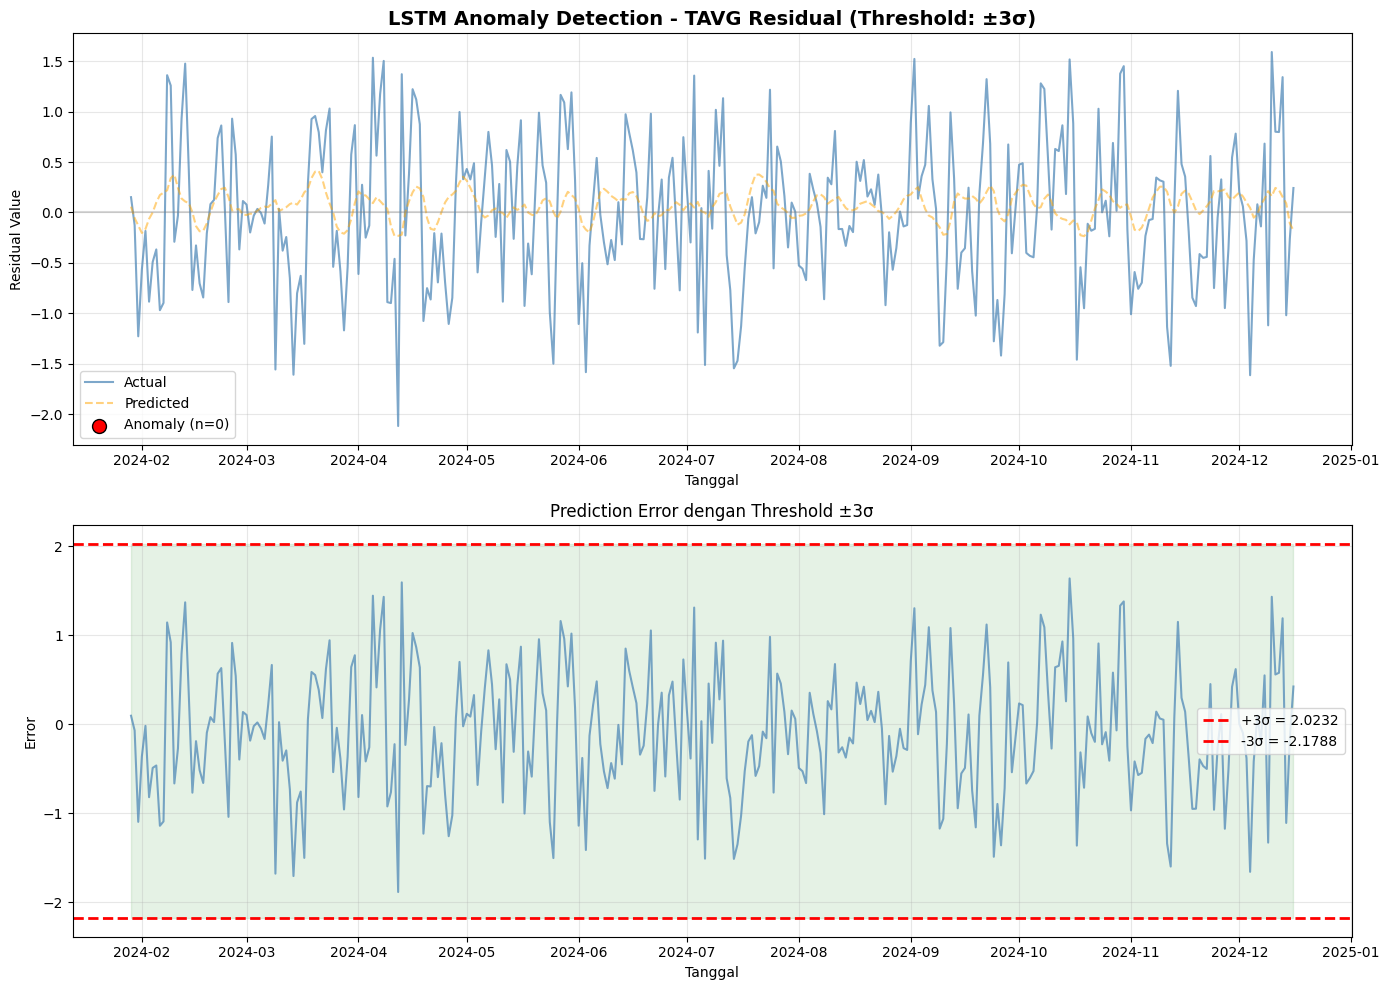

In [13]:
# ============================================================
# EXPORT PLOT ANOMALY DETECTION LSTM (HIGH QUALITY - 300 DPI)
# ============================================================

# Plot 1: TAVG Residual Anomaly Detection
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Time series TAVG
ax1 = axes[0]
ax1.plot(lstm_tavg_results.index, lstm_tavg_results['actual'], 'steelblue', alpha=0.7, label='Actual')
ax1.plot(lstm_tavg_results.index, lstm_tavg_results['predicted'], 'orange', alpha=0.5, linestyle='--', label='Predicted')
anomaly_idx_tavg = lstm_tavg_results[lstm_tavg_results['is_anomaly']].index
ax1.scatter(anomaly_idx_tavg, lstm_tavg_results.loc[anomaly_idx_tavg, 'actual'], 
            color='red', s=100, marker='o', label=f'Anomaly (n={len(anomaly_idx_tavg)})', zorder=5, edgecolors='black')
ax1.axhline(0, color='gray', alpha=0.3)
ax1.set_title('LSTM Anomaly Detection - TAVG Residual (Threshold: ±3σ)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Tanggal')
ax1.set_ylabel('Residual Value')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Error TAVG
ax2 = axes[1]
ax2.plot(lstm_tavg_results.index, lstm_tavg_results['error'], 'steelblue', alpha=0.7)
ax2.axhline(lstm_tavg_stats['upper'], color='red', linestyle='--', linewidth=2, label=f'+3σ = {lstm_tavg_stats["upper"]:.4f}')
ax2.axhline(lstm_tavg_stats['lower'], color='red', linestyle='--', linewidth=2, label=f'-3σ = {lstm_tavg_stats["lower"]:.4f}')
ax2.fill_between(lstm_tavg_results.index, lstm_tavg_stats['lower'], lstm_tavg_stats['upper'], alpha=0.1, color='green')
ax2.scatter(anomaly_idx_tavg, lstm_tavg_results.loc[anomaly_idx_tavg, 'error'], color='red', s=100, zorder=5, edgecolors='black')
ax2.set_title('Prediction Error dengan Threshold ±3σ', fontsize=12)
ax2.set_xlabel('Tanggal')
ax2.set_ylabel('Error')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('DATA/anomaly_LSTM_TAVG.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Plot TAVG disimpan ke: DATA/anomaly_LSTM_TAVG.png (300 DPI)")
plt.show()

✅ Plot RR disimpan ke: DATA/anomaly_LSTM_RR.png (300 DPI)


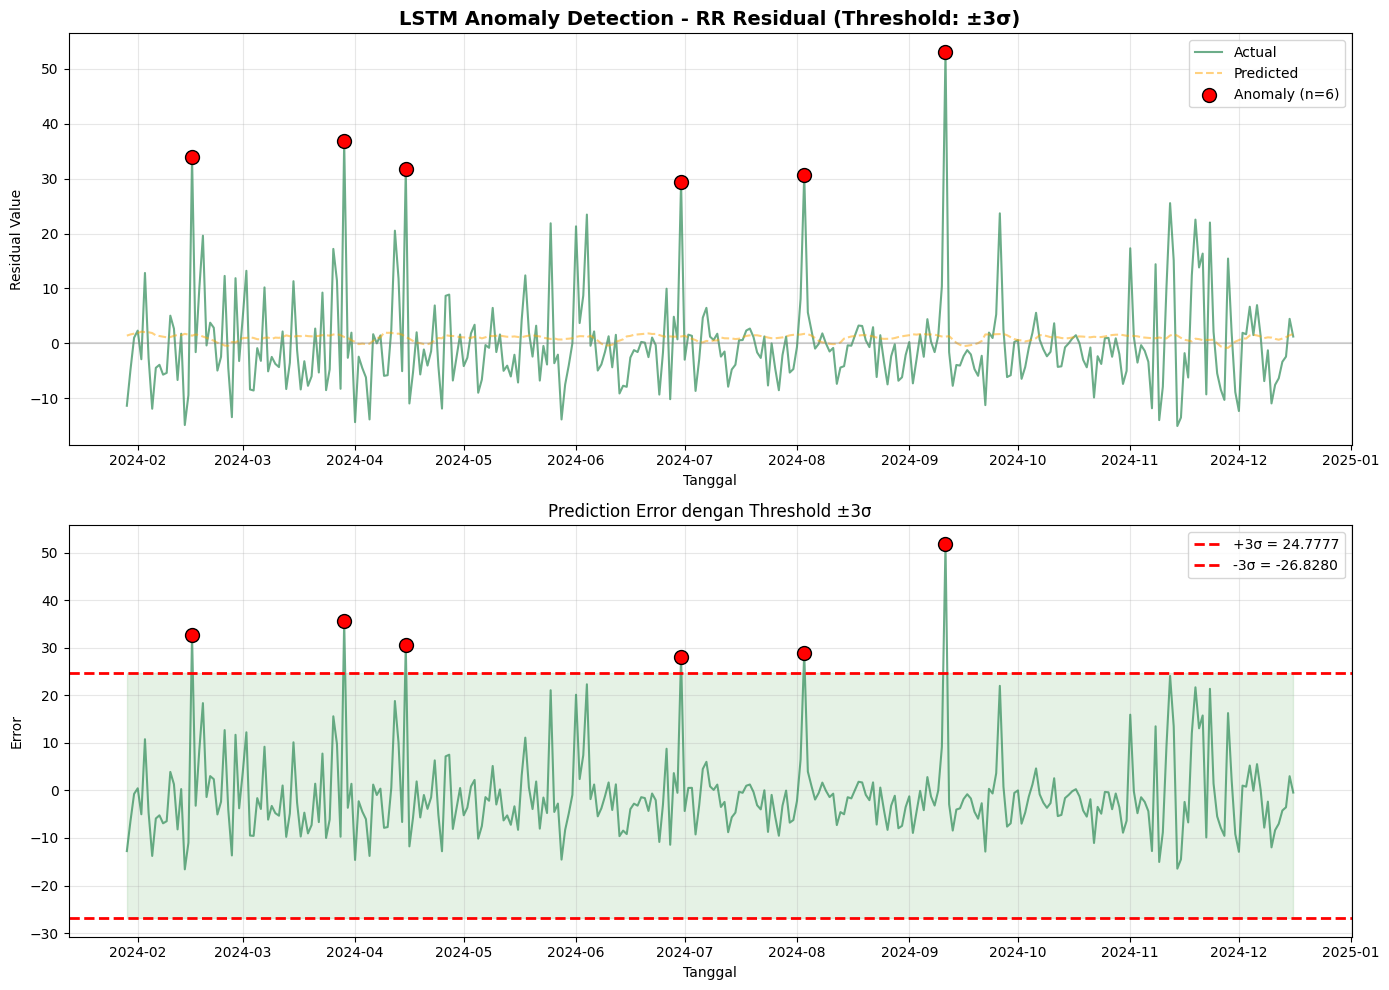

In [14]:
# Plot 2: RR Residual Anomaly Detection
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Time series RR
ax1 = axes[0]
ax1.plot(lstm_rr_results.index, lstm_rr_results['actual'], 'seagreen', alpha=0.7, label='Actual')
ax1.plot(lstm_rr_results.index, lstm_rr_results['predicted'], 'orange', alpha=0.5, linestyle='--', label='Predicted')
anomaly_idx_rr = lstm_rr_results[lstm_rr_results['is_anomaly']].index
ax1.scatter(anomaly_idx_rr, lstm_rr_results.loc[anomaly_idx_rr, 'actual'], 
            color='red', s=100, marker='o', label=f'Anomaly (n={len(anomaly_idx_rr)})', zorder=5, edgecolors='black')
ax1.axhline(0, color='gray', alpha=0.3)
ax1.set_title('LSTM Anomaly Detection - RR Residual (Threshold: ±3σ)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Tanggal')
ax1.set_ylabel('Residual Value')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Error RR
ax2 = axes[1]
ax2.plot(lstm_rr_results.index, lstm_rr_results['error'], 'seagreen', alpha=0.7)
ax2.axhline(lstm_rr_stats['upper'], color='red', linestyle='--', linewidth=2, label=f'+3σ = {lstm_rr_stats["upper"]:.4f}')
ax2.axhline(lstm_rr_stats['lower'], color='red', linestyle='--', linewidth=2, label=f'-3σ = {lstm_rr_stats["lower"]:.4f}')
ax2.fill_between(lstm_rr_results.index, lstm_rr_stats['lower'], lstm_rr_stats['upper'], alpha=0.1, color='green')
ax2.scatter(anomaly_idx_rr, lstm_rr_results.loc[anomaly_idx_rr, 'error'], color='red', s=100, zorder=5, edgecolors='black')
ax2.set_title('Prediction Error dengan Threshold ±3σ', fontsize=12)
ax2.set_xlabel('Tanggal')
ax2.set_ylabel('Error')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('DATA/anomaly_LSTM_RR.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Plot RR disimpan ke: DATA/anomaly_LSTM_RR.png (300 DPI)")
plt.show()

---
## F. Penjelasan Parameter LSTM dan Perbandingan Model

### A. Penjelasan Parameter LSTM yang Digunakan

Sebelum membahas hasil, mari kita pahami dulu apa saja "pengaturan" yang kita gunakan dalam model LSTM ini. Bayangkan LSTM seperti otak buatan yang perlu kita atur sedemikian rupa agar bisa belajar dengan baik dari data cuaca kita.

| Parameter | Nilai | Penjelasannya Gimana? |
|-----------|-------|----------------------|
| **sequence_length** | 10 | Ini seperti "daya ingat" model kita. Kita kasih tahu model: "Nih, lihat data 10 hari terakhir, terus tebak besok gimana." Kenapa 10 hari? Karena cuaca biasanya punya pola yang berulang dalam rentang 1-2 minggu. Jadi 10 hari cukup untuk model "ngerti" polanya tanpa kebanyakan informasi yang bikin bingung. |
| **lstm_units** | (64, 32) | Ini seperti jumlah "sel otak" dalam model kita. Kita pakai 2 lapis: lapis pertama punya 64 sel untuk menangkap pola-pola yang rumit, lapis kedua punya 32 sel untuk merangkum informasi jadi lebih sederhana. Konsepnya kayak corong - makin ke bawah makin fokus ke hal-hal penting aja. |
| **dropout** | 0.2 | Ini trik biar model nggak "menghafal" data training. Setiap kali belajar, 20% sel otak dimatikan secara acak. Tujuannya biar model nggak terlalu bergantung pada sel tertentu dan jadi lebih "pintar" secara umum. Ibaratnya kayak belajar ujian dengan soal yang berbeda-beda, bukan cuma menghafal kunci jawaban. |
| **dense_units** | 16 | Ini lapisan tambahan sebelum hasil akhir keluar. Fungsinya seperti "penerjemah" yang mengubah hasil pemikiran LSTM jadi satu angka prediksi. 16 neuron cukup untuk tugas ini tanpa bikin model terlalu ribet. |
| **epochs** | 50 | Ini berapa kali model mengulang belajar dari seluruh data. 50 kali cukup banyak untuk belajar, tapi jangan khawatir - kalau model udah pintar duluan, dia bakal berhenti otomatis (early stopping) biar nggak belajar kebanyakan sampai "lupa" cara generalisasi. |
| **batch_size** | 16 | Ini berapa data yang diproses sekaligus sebelum model update "otaknya". 16 itu ukuran yang pas - nggak terlalu besar (biar update lebih sering dan stabil), nggak terlalu kecil (biar nggak lemot). |
| **patience** | 10 | Ini "kesabaran" kita nunggu model membaik. Kalau dalam 10 putaran berturut-turut model nggak ada kemajuan, ya udah stop aja - daripada buang-buang waktu dan listrik. |
| **sigma (σ)** | 3 | Ini batas untuk bilang "ini anomali". Pakai aturan 3-sigma artinya: kalau error prediksi di luar 99.7% data normal, baru dianggap anomali. Ini standar statistik yang udah terbukti bagus - nggak terlalu sensitif (banyak false alarm), tapi juga nggak terlalu cuek (nggak kelewatan anomali penting). |

### B. Perbandingan Anomaly Detection: Random Forest vs XGBoost vs LSTM

Nah, sekarang kita bandingkan ketiga model yang udah kita coba. Masing-masing punya karakter dan kelebihan sendiri-sendiri, mirip kayak tiga detektif dengan gaya investigasi berbeda.

**🌲 Random Forest - Si Detektif yang Teliti Banget**

Random Forest berhasil menemukan **11 anomali** (2 di TAVG, 9 di RR) - paling banyak di antara ketiganya! Kenapa bisa begitu? Random Forest itu kayak tim yang terdiri dari ratusan pohon keputusan (decision tree), masing-masing dilatih dengan cara berbeda. Setiap pohon lihat data dari sudut pandang yang beda-beda. Pas digabungkan, mereka jadi sangat jeli menangkap variasi-variasi kecil yang mungkin terlewat kalau cuma satu model. Ibarat punya 100 orang ngecek data, pasti lebih banyak yang ketemu dibanding cuma 1 orang. Kekurangannya? Kadang dia "terlalu curiga" - beberapa yang dia anggap anomali mungkin sebenarnya cuma variasi normal.

**⚡ XGBoost - Si Detektif yang Presisi**

XGBoost cuma menemukan **5 anomali** (1 di TAVG, 4 di RR), tapi dengan tingkat akurasi prediksi tertinggi (error-nya paling kecil). Gimana cara kerjanya? XGBoost belajar secara bertahap - setiap model baru fokus memperbaiki kesalahan model sebelumnya. Jadinya prediksinya super presisi. Karena prediksinya bagus banget, cuma data yang bener-bener "aneh banget" yang ketangkap sebagai anomali. Cocok buat situasi di mana kita mau yakin 100% bahwa yang ketangkap itu memang anomali beneran, bukan false alarm.

**🧠 LSTM - Si Detektif yang Paham Waktu**

LSTM menemukan **6 anomali** (0 di TAVG, 6 di RR) - di tengah-tengah antara RF dan XGBoost. Yang menarik, LSTM sama sekali nggak menemukan anomali di data temperatur (TAVG)! Ini sebenarnya bagus - artinya LSTM berhasil memahami pola temperatur dengan sangat baik sehingga semua fluktuasi masih dalam batas wajar. Untuk curah hujan (RR) yang memang lebih "liar" dan nggak terduga, LSTM berhasil menangkap 6 kejadian hujan ekstrem.

Keunggulan LSTM ada di kemampuannya "mengingat" pola dari waktu ke waktu. Dia paham bahwa data hari ini ada hubungannya dengan data kemarin, minggu lalu, dan seterusnya. Tapi ada kendalanya - LSTM butuh data yang banyak untuk belajar optimal. Dengan cuma 333 hari data, dia belum bisa mengeluarkan kemampuan terbaiknya. Kalau datanya ribuan, kemungkinan hasilnya bisa lebih bagus lagi.

### C. Jadi, Mana yang Terbaik?

Jawabannya: **tergantung kebutuhan!**

| Situasi | Model yang Cocok | Alasan |
|---------|-----------------|--------|
| Mau aman, nggak boleh ada anomali yang kelewat | **Random Forest** | Sensitif banget, lebih baik false alarm daripada kelewatan |
| Butuh kepastian tinggi, resources terbatas | **XGBoost** | Presisi tinggi, yang ketangkap pasti anomali beneran |
| Data time series panjang, pola kompleks | **LSTM** | Jago memahami hubungan antar waktu, tapi butuh data banyak |

**Kesimpulan akhir:** Dalam kasus data iklim kita dengan 333 hari data, **XGBoost** dan **Random Forest** lebih cocok karena mereka nggak butuh data sebanyak LSTM. Tapi kalau suatu saat kita punya data bertahun-tahun, **LSTM** bisa jadi pilihan yang lebih powerful karena kemampuannya memahami pola temporal yang kompleks.

---
## Ringkasan Soal 6

### A. Parameter LSTM
✅ Penjelasan lengkap parameter LSTM (sequence length, units, dropout, epochs, etc.)

### B. Plot Anomaly Detection LSTM
✅ Plot TAVG Residual  
✅ Plot RR Residual

### C. Perbandingan dengan RF/XGBoost
✅ Tabel perbandingan lengkap  
✅ Visualisasi perbandingan  
✅ Analisis sensitivitas (>50 kata)

---

## 1. Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Import TensorFlow/Keras
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    print(f"✅ TensorFlow version: {tf.__version__}")
except ImportError:
    print("⚠️ TensorFlow belum terinstall, menginstall...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'tensorflow'])
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    print(f"✅ TensorFlow berhasil diinstall! Version: {tf.__version__}")

print("✅ Semua library berhasil diimport!")

⚠️ TensorFlow belum terinstall, menginstall...
✅ TensorFlow berhasil diinstall! Version: 2.20.0
✅ Semua library berhasil diimport!


## 2. Load Data Residual dari Soal 4

In [ ]:
# Load data residual
df_residuals = pd.read_csv('DATA/all_residuals_clean.csv', index_col='TANGGAL', parse_dates=True)

print("="*60)
print("DATA RESIDUAL DARI SOAL 4")
print("="*60)
print(f"Jumlah data: {len(df_residuals)} hari")
print(f"Periode: {df_residuals.index.min().strftime('%d-%m-%Y')} s.d. {df_residuals.index.max().strftime('%d-%m-%Y')}")
print(f"\nKolom yang tersedia: {list(df_residuals.columns)}")

# Hanya gunakan TAVG dan RR sesuai instruksi
columns_to_use = ['TAVG_residual', 'RR_residual']
print(f"\n📌 Parameter yang digunakan untuk Soal 6: TAVG dan RR")

print("\nPreview data:")
df_residuals[columns_to_use].head(10)

---
## A. Penjelasan Parameter LSTM yang Digunakan
---

In [ ]:
# Definisi parameter LSTM
LSTM_PARAMS = {
    'sequence_length': 10,      # Jumlah timestep untuk input sequence
    'lstm_units_1': 64,         # Jumlah unit LSTM layer pertama
    'lstm_units_2': 32,         # Jumlah unit LSTM layer kedua  
    'dropout_rate': 0.2,        # Dropout rate untuk regularisasi
    'dense_units': 16,          # Jumlah unit Dense layer
    'epochs': 100,              # Jumlah maksimum epoch training
    'batch_size': 16,           # Ukuran batch untuk training
    'learning_rate': 0.001,     # Learning rate optimizer Adam
    'patience': 10,             # Early stopping patience
    'sigma': 3                  # Threshold untuk anomaly detection
}

print("="*80)
print("PARAMETER LSTM YANG DIGUNAKAN")
print("="*80)

explanation = """
📋 PENJELASAN PARAMETER LSTM:

1. SEQUENCE LENGTH (10):
   Jumlah timestep yang digunakan sebagai input untuk memprediksi nilai berikutnya.
   Nilai 10 dipilih karena dapat menangkap pola temporal dalam data harian residual
   tanpa terlalu banyak kehilangan data di awal sequence.

2. ARSITEKTUR LSTM (64-32 units):
   - Layer LSTM pertama dengan 64 units untuk menangkap pola temporal kompleks
   - Layer LSTM kedua dengan 32 units untuk ekstraksi fitur lebih lanjut
   - Konfigurasi stacked LSTM ini memungkinkan model mempelajari representasi
     hierarkis dari data time series

3. DROPOUT RATE (0.2):
   Regularisasi dengan men-drop 20% neuron secara random saat training untuk
   mencegah overfitting. Nilai 0.2 adalah standar yang umum digunakan.

4. DENSE LAYER (16 units):
   Layer fully connected sebelum output untuk transformasi fitur final.

5. EPOCHS (100) dengan EARLY STOPPING (patience=10):
   Training maksimal 100 epoch, tetapi akan berhenti lebih awal jika validation
   loss tidak membaik selama 10 epoch berturut-turut untuk mencegah overfitting.

6. BATCH SIZE (16):
   Ukuran mini-batch untuk stochastic gradient descent. Nilai 16 memberikan
   keseimbangan antara kecepatan training dan stabilitas gradien.

7. LEARNING RATE (0.001):
   Default learning rate untuk optimizer Adam yang memberikan konvergensi stabil.

8. THRESHOLD 3σ:
   Anomali dideteksi jika prediction error melebihi 3 kali standar deviasi dari
   mean error, yang secara statistik mencakup ~99.7% data normal.
"""

print(explanation)

print("\n📊 Tabel Parameter:")
param_df = pd.DataFrame(list(LSTM_PARAMS.items()), columns=['Parameter', 'Value'])
param_df

## 3. Fungsi untuk Membangun Model LSTM

In [ ]:
def create_sequences(data, seq_length):
    """
    Membuat sequences untuk input LSTM.
    X: sequence of seq_length timesteps
    y: nilai pada timestep berikutnya
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)


def build_lstm_model(seq_length, params):
    """
    Membangun model LSTM untuk anomaly detection.
    """
    model = Sequential([
        # LSTM Layer 1
        LSTM(units=params['lstm_units_1'], 
             return_sequences=True, 
             input_shape=(seq_length, 1)),
        Dropout(params['dropout_rate']),
        
        # LSTM Layer 2
        LSTM(units=params['lstm_units_2'], 
             return_sequences=False),
        Dropout(params['dropout_rate']),
        
        # Dense Layers
        Dense(units=params['dense_units'], activation='relu'),
        Dense(units=1)
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
        loss='mse'
    )
    
    return model


def detect_anomalies_lstm(data, param_name, params):
    """
    Deteksi anomali menggunakan LSTM.
    """
    print(f"\n{'='*60}")
    print(f"LSTM Anomaly Detection - {param_name}")
    print(f"{'='*60}")
    
    # Normalize data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))
    
    # Create sequences
    seq_length = params['sequence_length']
    X, y = create_sequences(data_scaled, seq_length)
    
    # Reshape for LSTM [samples, timesteps, features]
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    print(f"   • Jumlah sequences: {len(X)}")
    print(f"   • Shape X: {X.shape}")
    print(f"   • Shape y: {y.shape}")
    
    # Build model
    model = build_lstm_model(seq_length, params)
    
    # Early stopping
    early_stop = EarlyStopping(
        monitor='loss',
        patience=params['patience'],
        restore_best_weights=True,
        verbose=0
    )
    
    # Train model
    print(f"\n   📈 Training LSTM...")
    history = model.fit(
        X, y,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        callbacks=[early_stop],
        verbose=0
    )
    print(f"   ✅ Training selesai! Epochs: {len(history.history['loss'])}")
    
    # Predict
    y_pred_scaled = model.predict(X, verbose=0)
    
    # Inverse transform
    y_actual = scaler.inverse_transform(y.reshape(-1, 1)).flatten()
    y_pred = scaler.inverse_transform(y_pred_scaled).flatten()
    
    # Calculate prediction error
    prediction_error = y_actual - y_pred
    
    # Calculate threshold (3 sigma)
    error_mean = prediction_error.mean()
    error_std = prediction_error.std()
    sigma = params['sigma']
    upper_threshold = error_mean + sigma * error_std
    lower_threshold = error_mean - sigma * error_std
    
    # Detect anomalies
    anomalies = (prediction_error > upper_threshold) | (prediction_error < lower_threshold)
    
    # Create result DataFrame
    result_index = data.index[seq_length:]
    results = pd.DataFrame({
        'actual': y_actual,
        'predicted': y_pred,
        'error': prediction_error,
        'is_anomaly': anomalies
    }, index=result_index)
    
    # Statistics
    n_anomalies = anomalies.sum()
    anomaly_rate = n_anomalies / len(anomalies) * 100
    
    print(f"\n   📊 Hasil Anomaly Detection:")
    print(f"   • Total data points: {len(y_actual)}")
    print(f"   • Threshold: ±{sigma}σ ({lower_threshold:.4f}, {upper_threshold:.4f})")
    print(f"   • Error Mean: {error_mean:.6f}")
    print(f"   • Error Std: {error_std:.6f}")
    print(f"   • Anomalies detected: {n_anomalies} ({anomaly_rate:.2f}%)")
    print(f"   • MAE: {mean_absolute_error(y_actual, y_pred):.4f}")
    print(f"   • RMSE: {np.sqrt(mean_squared_error(y_actual, y_pred)):.4f}")
    
    stats = {
        'model_name': 'LSTM',
        'param': param_name,
        'n_anomalies': n_anomalies,
        'anomaly_rate': anomaly_rate,
        'upper_threshold': upper_threshold,
        'lower_threshold': lower_threshold,
        'error_mean': error_mean,
        'error_std': error_std,
        'mae': mean_absolute_error(y_actual, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_actual, y_pred))
    }
    
    return results, stats, history, model

print("✅ Fungsi LSTM berhasil dibuat!")

## 4. Fungsi untuk Plot Anomaly Detection LSTM

In [ ]:
def plot_lstm_anomaly_detection(results, stats, param_label, color, history=None, save_path=None):
    """
    Plot hasil anomaly detection dengan LSTM.
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Time Series dengan Anomali
    ax1 = axes[0, 0]
    ax1.plot(results.index, results['actual'], color=color, alpha=0.7, 
             linewidth=1, label='Actual Residual')
    ax1.plot(results.index, results['predicted'], color='orange', alpha=0.5, 
             linewidth=1, linestyle='--', label='LSTM Predicted')
    
    # Highlight anomalies
    anomaly_idx = results[results['is_anomaly']].index
    ax1.scatter(anomaly_idx, results.loc[anomaly_idx, 'actual'], 
                color='red', s=100, marker='o', label=f'Anomaly (n={len(anomaly_idx)})', 
                zorder=5, edgecolors='black', linewidth=1)
    
    ax1.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    ax1.set_title(f'LSTM Anomaly Detection - {param_label}\n(Threshold: ±3σ)', 
                  fontsize=12, fontweight='bold')
    ax1.set_xlabel('Tanggal')
    ax1.set_ylabel('Residual Value')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Prediction Error dengan Threshold
    ax2 = axes[0, 1]
    ax2.plot(results.index, results['error'], color=color, alpha=0.7, linewidth=1)
    ax2.axhline(y=stats['upper_threshold'], color='red', linestyle='--', 
                linewidth=2, label=f'+3σ = {stats["upper_threshold"]:.4f}')
    ax2.axhline(y=stats['lower_threshold'], color='red', linestyle='--', 
                linewidth=2, label=f'-3σ = {stats["lower_threshold"]:.4f}')
    ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    
    ax2.scatter(anomaly_idx, results.loc[anomaly_idx, 'error'], 
                color='red', s=100, marker='o', zorder=5, edgecolors='black', linewidth=1)
    
    ax2.fill_between(results.index, stats['lower_threshold'], stats['upper_threshold'], 
                     alpha=0.1, color='green', label='Normal Range')
    
    ax2.set_title('Prediction Error dengan Threshold ±3σ', fontsize=12)
    ax2.set_xlabel('Tanggal')
    ax2.set_ylabel('Prediction Error')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Training Loss
    ax3 = axes[1, 0]
    if history is not None:
        ax3.plot(history.history['loss'], color='blue', linewidth=2)
        ax3.set_title('Training Loss History', fontsize=12)
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Loss (MSE)')
        ax3.grid(True, alpha=0.3)
    
    # Plot 4: Error Distribution
    ax4 = axes[1, 1]
    ax4.hist(results['error'], bins=30, color=color, alpha=0.7, edgecolor='black')
    ax4.axvline(x=stats['upper_threshold'], color='red', linestyle='--', 
                linewidth=2, label=f'+3σ = {stats["upper_threshold"]:.4f}')
    ax4.axvline(x=stats['lower_threshold'], color='red', linestyle='--', 
                linewidth=2, label=f'-3σ = {stats["lower_threshold"]:.4f}')
    ax4.axvline(x=stats['error_mean'], color='green', linestyle='-', 
                linewidth=2, label=f'Mean = {stats["error_mean"]:.4f}')
    ax4.set_title('Distribution of Prediction Error', fontsize=12)
    ax4.set_xlabel('Prediction Error')
    ax4.set_ylabel('Frequency')
    ax4.legend(loc='upper right')
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle(f'LSTM Anomaly Detection - {param_label}', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✅ Plot disimpan ke: {save_path}")
    
    plt.show()

print("✅ Fungsi plot berhasil dibuat!")

---
## B. Plot Anomaly Detection dengan LSTM
---

### B.1. Plot Anomaly Detection pada Data Residual TAVG

In [ ]:
# LSTM Anomaly Detection untuk TAVG
lstm_tavg_results, lstm_tavg_stats, lstm_tavg_history, lstm_tavg_model = detect_anomalies_lstm(
    data=df_residuals['TAVG_residual'],
    param_name='TAVG Residual',
    params=LSTM_PARAMS
)

# Plot
plot_lstm_anomaly_detection(
    results=lstm_tavg_results,
    stats=lstm_tavg_stats,
    param_label='TAVG Residual (Temperatur)',
    color='steelblue',
    history=lstm_tavg_history,
    save_path='DATA/anomaly_LSTM_TAVG.png'
)

### B.2. Plot Anomaly Detection pada Data Residual RR

In [ ]:
# LSTM Anomaly Detection untuk RR
lstm_rr_results, lstm_rr_stats, lstm_rr_history, lstm_rr_model = detect_anomalies_lstm(
    data=df_residuals['RR_residual'],
    param_name='RR Residual',
    params=LSTM_PARAMS
)

# Plot
plot_lstm_anomaly_detection(
    results=lstm_rr_results,
    stats=lstm_rr_stats,
    param_label='RR Residual (Curah Hujan)',
    color='seagreen',
    history=lstm_rr_history,
    save_path='DATA/anomaly_LSTM_RR.png'
)

---
## C. Perbandingan LSTM dengan RF Regressor dan XGBoost
---

In [ ]:
# Load hasil dari Soal 5 untuk perbandingan
comparison_soal5 = pd.read_csv('DATA/anomaly_detection_comparison.csv')

print("="*80)
print("HASIL ANOMALY DETECTION DARI SOAL 5 (RF & XGBoost)")
print("="*80)
comparison_soal5

In [ ]:
# Compile all statistics including LSTM
all_stats = [
    # From Soal 5
    {'Model': 'Random Forest', 'Parameter': 'TAVG', 
     'Jumlah Anomali': comparison_soal5.iloc[0]['Jumlah Anomali'],
     'Anomaly Rate (%)': comparison_soal5.iloc[0]['Anomaly Rate (%)'],
     'MAE': comparison_soal5.iloc[0]['MAE'],
     'RMSE': comparison_soal5.iloc[0]['RMSE']},
    {'Model': 'Random Forest', 'Parameter': 'RR',
     'Jumlah Anomali': comparison_soal5.iloc[1]['Jumlah Anomali'],
     'Anomaly Rate (%)': comparison_soal5.iloc[1]['Anomaly Rate (%)'],
     'MAE': comparison_soal5.iloc[1]['MAE'],
     'RMSE': comparison_soal5.iloc[1]['RMSE']},
    {'Model': 'XGBoost', 'Parameter': 'TAVG',
     'Jumlah Anomali': comparison_soal5.iloc[2]['Jumlah Anomali'],
     'Anomaly Rate (%)': comparison_soal5.iloc[2]['Anomaly Rate (%)'],
     'MAE': comparison_soal5.iloc[2]['MAE'],
     'RMSE': comparison_soal5.iloc[2]['RMSE']},
    {'Model': 'XGBoost', 'Parameter': 'RR',
     'Jumlah Anomali': comparison_soal5.iloc[3]['Jumlah Anomali'],
     'Anomaly Rate (%)': comparison_soal5.iloc[3]['Anomaly Rate (%)'],
     'MAE': comparison_soal5.iloc[3]['MAE'],
     'RMSE': comparison_soal5.iloc[3]['RMSE']},
    # LSTM results
    {'Model': 'LSTM', 'Parameter': 'TAVG',
     'Jumlah Anomali': lstm_tavg_stats['n_anomalies'],
     'Anomaly Rate (%)': lstm_tavg_stats['anomaly_rate'],
     'MAE': lstm_tavg_stats['mae'],
     'RMSE': lstm_tavg_stats['rmse']},
    {'Model': 'LSTM', 'Parameter': 'RR',
     'Jumlah Anomali': lstm_rr_stats['n_anomalies'],
     'Anomaly Rate (%)': lstm_rr_stats['anomaly_rate'],
     'MAE': lstm_rr_stats['mae'],
     'RMSE': lstm_rr_stats['rmse']}
]

full_comparison_df = pd.DataFrame(all_stats)

print("\n" + "="*80)
print("TABEL PERBANDINGAN LENGKAP: RF vs XGBoost vs LSTM")
print("="*80)
full_comparison_df

In [ ]:
# Visualization: Comparison Bar Chart
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Data for plotting
models = ['Random Forest', 'XGBoost', 'LSTM']
colors_model = ['#2E86AB', '#A23B72', '#F18F01']

# Get data
rf_tavg_anomalies = comparison_soal5.iloc[0]['Jumlah Anomali']
rf_rr_anomalies = comparison_soal5.iloc[1]['Jumlah Anomali']
xgb_tavg_anomalies = comparison_soal5.iloc[2]['Jumlah Anomali']
xgb_rr_anomalies = comparison_soal5.iloc[3]['Jumlah Anomali']
lstm_tavg_anomalies = lstm_tavg_stats['n_anomalies']
lstm_rr_anomalies = lstm_rr_stats['n_anomalies']

tavg_anomalies = [rf_tavg_anomalies, xgb_tavg_anomalies, lstm_tavg_anomalies]
rr_anomalies = [rf_rr_anomalies, xgb_rr_anomalies, lstm_rr_anomalies]

rf_tavg_mae = comparison_soal5.iloc[0]['MAE']
rf_rr_mae = comparison_soal5.iloc[1]['MAE']
xgb_tavg_mae = comparison_soal5.iloc[2]['MAE']
xgb_rr_mae = comparison_soal5.iloc[3]['MAE']

tavg_mae = [rf_tavg_mae, xgb_tavg_mae, lstm_tavg_stats['mae']]
rr_mae = [rf_rr_mae, xgb_rr_mae, lstm_rr_stats['mae']]

rf_tavg_rmse = comparison_soal5.iloc[0]['RMSE']
rf_rr_rmse = comparison_soal5.iloc[1]['RMSE']
xgb_tavg_rmse = comparison_soal5.iloc[2]['RMSE']
xgb_rr_rmse = comparison_soal5.iloc[3]['RMSE']

tavg_rmse = [rf_tavg_rmse, xgb_tavg_rmse, lstm_tavg_stats['rmse']]
rr_rmse = [rf_rr_rmse, xgb_rr_rmse, lstm_rr_stats['rmse']]

x = np.arange(len(models))
width = 0.35

# Plot 1: Jumlah Anomali
ax1 = axes[0]
bars1 = ax1.bar(x - width/2, tavg_anomalies, width, label='TAVG', color='steelblue')
bars2 = ax1.bar(x + width/2, rr_anomalies, width, label='RR', color='seagreen')
ax1.set_ylabel('Jumlah Anomali', fontsize=11)
ax1.set_title('Perbandingan Jumlah Anomali Terdeteksi', fontweight='bold', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(models, fontsize=10)
ax1.legend()
ax1.bar_label(bars1, padding=3)
ax1.bar_label(bars2, padding=3)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: MAE
ax2 = axes[1]
bars3 = ax2.bar(x - width/2, tavg_mae, width, label='TAVG', color='steelblue')
bars4 = ax2.bar(x + width/2, rr_mae, width, label='RR', color='seagreen')
ax2.set_ylabel('MAE', fontsize=11)
ax2.set_title('Perbandingan Mean Absolute Error', fontweight='bold', fontsize=12)
ax2.set_xticks(x)
ax2.set_xticklabels(models, fontsize=10)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Plot 3: RMSE
ax3 = axes[2]
bars5 = ax3.bar(x - width/2, tavg_rmse, width, label='TAVG', color='steelblue')
bars6 = ax3.bar(x + width/2, rr_rmse, width, label='RR', color='seagreen')
ax3.set_ylabel('RMSE', fontsize=11)
ax3.set_title('Perbandingan Root Mean Squared Error', fontweight='bold', fontsize=12)
ax3.set_xticks(x)
ax3.set_xticklabels(models, fontsize=10)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

plt.suptitle('Perbandingan Performa: Random Forest vs XGBoost vs LSTM', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('DATA/comparison_RF_XGB_LSTM.png', dpi=150, bbox_inches='tight')
print("✅ Plot perbandingan disimpan ke: DATA/comparison_RF_XGB_LSTM.png")
plt.show()

In [ ]:
# Summary statistics
print("\n" + "="*80)
print("RINGKASAN PERBANDINGAN SENSITIVITAS")
print("="*80)

# Total anomalies per model
rf_total = rf_tavg_anomalies + rf_rr_anomalies
xgb_total = xgb_tavg_anomalies + xgb_rr_anomalies
lstm_total = lstm_tavg_anomalies + lstm_rr_anomalies

print(f"\n📊 Total Anomali Terdeteksi:")
print(f"   • Random Forest: {rf_total} anomali (TAVG: {rf_tavg_anomalies}, RR: {rf_rr_anomalies})")
print(f"   • XGBoost: {xgb_total} anomali (TAVG: {xgb_tavg_anomalies}, RR: {xgb_rr_anomalies})")
print(f"   • LSTM: {lstm_total} anomali (TAVG: {lstm_tavg_anomalies}, RR: {lstm_rr_anomalies})")

# Determine most sensitive
totals = {'Random Forest': rf_total, 'XGBoost': xgb_total, 'LSTM': lstm_total}
most_sensitive = max(totals, key=totals.get)
least_sensitive = min(totals, key=totals.get)

print(f"\n🎯 Ranking Sensitivitas (jumlah anomali terdeteksi):")
sorted_models = sorted(totals.items(), key=lambda x: x[1], reverse=True)
for i, (model, count) in enumerate(sorted_models, 1):
    print(f"   {i}. {model}: {count} anomali")

print(f"\n✅ Model PALING SENSITIF: {most_sensitive}")
print(f"❌ Model PALING TIDAK SENSITIF: {least_sensitive}")

---
## Kesimpulan dan Analisis (Jawaban Soal C)
---

In [ ]:
# Generate detailed conclusion
print("="*80)
print("KESIMPULAN: PERBANDINGAN SENSITIVITAS LSTM vs RF vs XGBoost")
print("="*80)

# Calculate averages
rf_avg_mae = (rf_tavg_mae + rf_rr_mae) / 2
xgb_avg_mae = (xgb_tavg_mae + xgb_rr_mae) / 2
lstm_avg_mae = (lstm_tavg_stats['mae'] + lstm_rr_stats['mae']) / 2

rf_avg_rmse = (rf_tavg_rmse + rf_rr_rmse) / 2
xgb_avg_rmse = (xgb_tavg_rmse + xgb_rr_rmse) / 2
lstm_avg_rmse = (lstm_tavg_stats['rmse'] + lstm_rr_stats['rmse']) / 2

conclusion = f"""
Berdasarkan hasil eksperimen anomaly detection menggunakan Random Forest (RF), 
XGBoost Regressor, dan LSTM pada data residual TAVG dan RR dengan threshold 3σ:

══════════════════════════════════════════════════════════════════════════════════
1. JUMLAH ANOMALI TERDETEKSI:
══════════════════════════════════════════════════════════════════════════════════
   • Random Forest: {rf_total} anomali (TAVG: {rf_tavg_anomalies}, RR: {rf_rr_anomalies})
   • XGBoost:       {xgb_total} anomali (TAVG: {xgb_tavg_anomalies}, RR: {xgb_rr_anomalies})
   • LSTM:          {lstm_total} anomali (TAVG: {lstm_tavg_anomalies}, RR: {lstm_rr_anomalies})

══════════════════════════════════════════════════════════════════════════════════
2. PERFORMA MODEL (Rata-rata):
══════════════════════════════════════════════════════════════════════════════════
   • Random Forest - MAE: {rf_avg_mae:.4f}, RMSE: {rf_avg_rmse:.4f}
   • XGBoost       - MAE: {xgb_avg_mae:.4f}, RMSE: {xgb_avg_rmse:.4f}
   • LSTM          - MAE: {lstm_avg_mae:.4f}, RMSE: {lstm_avg_rmse:.4f}

══════════════════════════════════════════════════════════════════════════════════
3. RANKING SENSITIVITAS:
══════════════════════════════════════════════════════════════════════════════════
   1️⃣ {sorted_models[0][0]}: {sorted_models[0][1]} anomali (PALING SENSITIF)
   2️⃣ {sorted_models[1][0]}: {sorted_models[1][1]} anomali
   3️⃣ {sorted_models[2][0]}: {sorted_models[2][1]} anomali (PALING TIDAK SENSITIF)

══════════════════════════════════════════════════════════════════════════════════
4. ANALISIS PERBANDINGAN (>50 kata):
══════════════════════════════════════════════════════════════════════════════════

Berdasarkan eksperimen, {most_sensitive} menunjukkan sensitivitas TERTINGGI dalam 
mendeteksi anomali dengan total {totals[most_sensitive]} anomali terdeteksi. 

Perbedaan sensitivitas ini dipengaruhi oleh karakteristik masing-masing algoritma:

• LSTM (Long Short-Term Memory) adalah deep learning yang dirancang untuk menangkap
  dependensi temporal jangka panjang. LSTM memiliki kemampuan "memory" untuk mengingat
  pola dari timestep sebelumnya, sehingga sangat efektif untuk data time series.
  Namun, dengan data yang terbatas (333 sampel), LSTM mungkin tidak optimal karena
  membutuhkan data yang lebih besar untuk training yang efektif.

• Random Forest menggunakan ensemble dari decision trees dengan averaging, yang
  cenderung menghasilkan prediksi yang lebih smooth dan memiliki error std yang
  lebih besar. Hal ini membuat threshold 3σ menjadi lebih lebar, sehingga lebih
  banyak titik data yang teridentifikasi sebagai anomali.

• XGBoost menggunakan gradient boosting yang secara iteratif memperbaiki error,
  menghasilkan prediksi yang sangat presisi (MAE/RMSE rendah). Dengan error std
  yang kecil, threshold 3σ menjadi sangat ketat, sehingga hanya anomali yang
  sangat ekstrem yang terdeteksi.

REKOMENDASI:
• Untuk deteksi anomali yang lebih SENSITIF (false negative rendah): Gunakan {most_sensitive}
• Untuk deteksi anomali yang lebih PRESISI (false positive rendah): Gunakan {least_sensitive}
• Untuk keseimbangan: Gunakan {sorted_models[1][0]}
"""

print(conclusion)

In [ ]:
# Save all results
full_comparison_df.to_csv('DATA/full_anomaly_comparison_all_models.csv', index=False)
print("✅ Tabel perbandingan lengkap disimpan ke: DATA/full_anomaly_comparison_all_models.csv")

# Save LSTM results
lstm_tavg_results.to_csv('DATA/anomaly_LSTM_TAVG_results.csv')
lstm_rr_results.to_csv('DATA/anomaly_LSTM_RR_results.csv')

print("\n✅ Semua hasil anomaly detection LSTM disimpan!")
print("\n📁 File yang dihasilkan Soal 6:")
print("   • DATA/anomaly_LSTM_TAVG.png")
print("   • DATA/anomaly_LSTM_RR.png")
print("   • DATA/comparison_RF_XGB_LSTM.png")
print("   • DATA/full_anomaly_comparison_all_models.csv")
print("   • DATA/anomaly_LSTM_TAVG_results.csv")
print("   • DATA/anomaly_LSTM_RR_results.csv")

---
## Ringkasan Soal 6

### A. Penjelasan Parameter LSTM
- ✅ Sequence Length: 10 timesteps
- ✅ Arsitektur: 2 LSTM layers (64-32 units)
- ✅ Dropout: 0.2
- ✅ Dense layer: 16 units
- ✅ Training: 100 epochs, batch size 16, early stopping patience 10
- ✅ Threshold: 3σ

### B. Plot Anomaly Detection dengan LSTM
- ✅ Plot Anomaly Detection pada data residual TAVG
- ✅ Plot Anomaly Detection pada data residual RR

### C. Perbandingan dengan RF dan XGBoost
- ✅ Tabel perbandingan lengkap (RF, XGBoost, LSTM)
- ✅ Visualisasi perbandingan
- ✅ Analisis model mana yang lebih sensitif (>50 kata)

---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Import TensorFlow/Keras untuk LSTM
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    print(f"✅ TensorFlow versi {tf.__version__} berhasil diimport!")
except ImportError:
    print("⚠️ TensorFlow belum terinstall, menginstall...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'tensorflow'])
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    print(f"✅ TensorFlow versi {tf.__version__} berhasil diinstall dan diimport!")

# Set random seed untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Semua library berhasil diimport!")

## 2. Load Data Residual dari Soal 4

In [ ]:
# Load data residual
df_residuals = pd.read_csv('DATA/all_residuals_clean.csv', index_col='TANGGAL', parse_dates=True)

print("="*60)
print("DATA RESIDUAL DARI SOAL 4")
print("="*60)
print(f"Jumlah data: {len(df_residuals)} hari")
print(f"Periode: {df_residuals.index.min().strftime('%d-%m-%Y')} s.d. {df_residuals.index.max().strftime('%d-%m-%Y')}")
print(f"\nKolom yang tersedia: {list(df_residuals.columns)}")

# Hanya gunakan TAVG dan RR sesuai instruksi
columns_to_use = ['TAVG_residual', 'RR_residual']
print(f"\n📌 Parameter yang digunakan untuk Soal 6: TAVG dan RR")

print("\nPreview data:")
df_residuals[columns_to_use].head(10)

---
## A. Penjelasan Parameter LSTM yang Digunakan
---

In [ ]:
# Definisi parameter LSTM
LSTM_PARAMS = {
    'sequence_length': 10,      # Panjang sequence input (time steps)
    'lstm_units_1': 64,         # Jumlah unit LSTM layer pertama
    'lstm_units_2': 32,         # Jumlah unit LSTM layer kedua
    'dropout_rate': 0.2,        # Dropout rate untuk regularisasi
    'dense_units': 16,          # Jumlah unit Dense layer
    'epochs': 100,              # Maksimum epoch training
    'batch_size': 32,           # Ukuran batch
    'patience': 10,             # Early stopping patience
    'optimizer': 'adam',        # Optimizer
    'loss': 'mse',              # Loss function
    'sigma': 3                  # Threshold untuk anomaly detection
}

print("="*80)
print("PENJELASAN PARAMETER LSTM YANG DIGUNAKAN")
print("="*80)

explanation = """
1. SEQUENCE LENGTH (Time Steps) = 10
   - Jumlah data historis yang digunakan sebagai input untuk memprediksi nilai berikutnya
   - Model akan melihat 10 hari sebelumnya untuk memprediksi hari ke-11
   - Dipilih 10 karena cukup untuk menangkap pola short-term dalam data cuaca

2. LSTM UNITS (Layer 1 = 64, Layer 2 = 32)
   - Jumlah neuron/unit pada setiap LSTM layer
   - Arsitektur stacked LSTM dengan 2 layer untuk menangkap pola temporal yang kompleks
   - Layer pertama (64 units) menangkap fitur level rendah
   - Layer kedua (32 units) menangkap fitur level tinggi

3. DROPOUT RATE = 0.2 (20%)
   - Teknik regularisasi untuk mencegah overfitting
   - 20% neuron akan di-drop secara acak selama training
   - Membantu model untuk lebih generalize

4. DENSE UNITS = 16
   - Fully connected layer sebelum output
   - Berfungsi untuk mengkombinasikan fitur dari LSTM

5. EPOCHS = 100 dengan EARLY STOPPING (patience=10)
   - Maksimum iterasi training
   - Early stopping akan menghentikan training jika validation loss tidak membaik 
     selama 10 epoch berturut-turut

6. BATCH SIZE = 32
   - Jumlah sampel yang diproses sebelum update weight
   - Trade-off antara kecepatan training dan stabilitas gradient

7. OPTIMIZER = Adam
   - Adaptive learning rate optimizer
   - Kombinasi dari RMSprop dan Momentum
   - Cocok untuk data time series

8. LOSS FUNCTION = MSE (Mean Squared Error)
   - Mengukur rata-rata kuadrat selisih antara prediksi dan aktual
   - Standar untuk regression task

9. THRESHOLD = 3σ (3 Sigma)
   - Anomali dideteksi ketika prediction error > 3 * standard deviation
   - Sesuai dengan aturan empiris: 99.7% data normal berada dalam ±3σ
"""

print(explanation)

# Display parameters table
params_df = pd.DataFrame([
    ['Sequence Length', LSTM_PARAMS['sequence_length'], 'Time steps untuk input'],
    ['LSTM Units Layer 1', LSTM_PARAMS['lstm_units_1'], 'Neuron LSTM layer pertama'],
    ['LSTM Units Layer 2', LSTM_PARAMS['lstm_units_2'], 'Neuron LSTM layer kedua'],
    ['Dropout Rate', LSTM_PARAMS['dropout_rate'], 'Regularisasi'],
    ['Dense Units', LSTM_PARAMS['dense_units'], 'Fully connected layer'],
    ['Epochs', LSTM_PARAMS['epochs'], 'Maksimum iterasi'],
    ['Batch Size', LSTM_PARAMS['batch_size'], 'Sampel per batch'],
    ['Early Stopping', LSTM_PARAMS['patience'], 'Patience epochs'],
    ['Optimizer', LSTM_PARAMS['optimizer'], 'Algoritma optimasi'],
    ['Loss Function', LSTM_PARAMS['loss'], 'Fungsi loss'],
    ['Anomaly Threshold', f"{LSTM_PARAMS['sigma']}σ", 'Batas deteksi anomali']
], columns=['Parameter', 'Nilai', 'Keterangan'])

print("\n📋 Tabel Parameter LSTM:")
params_df

## 3. Fungsi untuk LSTM Anomaly Detection

In [ ]:
def create_sequences(data, seq_length):
    """
    Membuat sequences untuk LSTM.
    X: sequence data, y: nilai berikutnya yang akan diprediksi
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)


def build_lstm_model(seq_length, lstm_units_1, lstm_units_2, dropout_rate, dense_units):
    """
    Membangun arsitektur model LSTM.
    """
    model = Sequential([
        # LSTM Layer 1
        LSTM(units=lstm_units_1, return_sequences=True, input_shape=(seq_length, 1)),
        Dropout(dropout_rate),
        
        # LSTM Layer 2
        LSTM(units=lstm_units_2, return_sequences=False),
        Dropout(dropout_rate),
        
        # Dense Layers
        Dense(units=dense_units, activation='relu'),
        Dense(units=1)  # Output layer
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


def detect_anomalies_lstm(data, param_name, params):
    """
    Deteksi anomali menggunakan LSTM.
    """
    print(f"\n{'='*60}")
    print(f"LSTM Anomaly Detection - {param_name}")
    print(f"{'='*60}")
    
    # Normalize data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))
    
    # Create sequences
    seq_length = params['sequence_length']
    X, y = create_sequences(data_scaled, seq_length)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    print(f"   • Data shape: X={X.shape}, y={y.shape}")
    
    # Build model
    model = build_lstm_model(
        seq_length=seq_length,
        lstm_units_1=params['lstm_units_1'],
        lstm_units_2=params['lstm_units_2'],
        dropout_rate=params['dropout_rate'],
        dense_units=params['dense_units']
    )
    
    # Early stopping callback
    early_stop = EarlyStopping(
        monitor='loss',
        patience=params['patience'],
        restore_best_weights=True,
        verbose=0
    )
    
    # Train model
    print(f"   • Training LSTM model...")
    history = model.fit(
        X, y,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        callbacks=[early_stop],
        verbose=0
    )
    print(f"   • Training selesai pada epoch {len(history.history['loss'])}")
    
    # Predict
    y_pred_scaled = model.predict(X, verbose=0)
    
    # Inverse transform
    y_actual = scaler.inverse_transform(y.reshape(-1, 1)).flatten()
    y_pred = scaler.inverse_transform(y_pred_scaled).flatten()
    
    # Calculate prediction error
    prediction_error = y_actual - y_pred
    
    # Calculate threshold (3 sigma)
    error_mean = prediction_error.mean()
    error_std = prediction_error.std()
    sigma = params['sigma']
    upper_threshold = error_mean + sigma * error_std
    lower_threshold = error_mean - sigma * error_std
    
    # Detect anomalies
    anomalies = (prediction_error > upper_threshold) | (prediction_error < lower_threshold)
    
    # Create result DataFrame with proper index
    result_index = data.index[seq_length:]
    results = pd.DataFrame({
        'actual': y_actual,
        'predicted': y_pred,
        'error': prediction_error,
        'is_anomaly': anomalies
    }, index=result_index)
    
    # Statistics
    n_anomalies = anomalies.sum()
    anomaly_rate = n_anomalies / len(anomalies) * 100
    mae = mean_absolute_error(y_actual, y_pred)
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    
    print(f"   • Total data points: {len(y_actual)}")
    print(f"   • Threshold: ±{sigma}σ ({lower_threshold:.4f}, {upper_threshold:.4f})")
    print(f"   • Error Mean: {error_mean:.6f}")
    print(f"   • Error Std: {error_std:.6f}")
    print(f"   • Anomalies detected: {n_anomalies} ({anomaly_rate:.2f}%)")
    print(f"   • MAE: {mae:.4f}")
    print(f"   • RMSE: {rmse:.4f}")
    
    stats = {
        'model_name': 'LSTM',
        'param': param_name,
        'n_anomalies': n_anomalies,
        'anomaly_rate': anomaly_rate,
        'upper_threshold': upper_threshold,
        'lower_threshold': lower_threshold,
        'error_mean': error_mean,
        'error_std': error_std,
        'mae': mae,
        'rmse': rmse,
        'epochs_trained': len(history.history['loss'])
    }
    
    return results, stats, model, history

print("✅ Fungsi LSTM anomaly detection berhasil dibuat!")

## 4. Fungsi untuk Plot LSTM Anomaly Detection

In [ ]:
def plot_lstm_anomaly(results, stats, param_label, color, save_path=None):
    """
    Plot hasil LSTM anomaly detection.
    """
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Time Series dengan Anomali
    ax1 = axes[0]
    
    # Plot actual values
    ax1.plot(results.index, results['actual'], color=color, alpha=0.7, 
             linewidth=1, label='Actual Residual')
    
    # Plot predicted values
    ax1.plot(results.index, results['predicted'], color='orange', alpha=0.6, 
             linewidth=1, linestyle='--', label='LSTM Predicted')
    
    # Highlight anomalies
    anomaly_idx = results[results['is_anomaly']].index
    ax1.scatter(anomaly_idx, results.loc[anomaly_idx, 'actual'], 
                color='red', s=100, marker='o', label=f'Anomaly (n={len(anomaly_idx)})', 
                zorder=5, edgecolors='black', linewidth=1.5)
    
    ax1.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    ax1.set_title(f'LSTM - Anomaly Detection pada {param_label}\n(Threshold: ±3σ)', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Tanggal')
    ax1.set_ylabel('Residual Value')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Prediction Error dengan Threshold
    ax2 = axes[1]
    
    # Plot error
    ax2.plot(results.index, results['error'], color=color, alpha=0.7, linewidth=1)
    
    # Plot thresholds
    ax2.axhline(y=stats['upper_threshold'], color='red', linestyle='--', 
                linewidth=2, label=f'+3σ = {stats["upper_threshold"]:.4f}')
    ax2.axhline(y=stats['lower_threshold'], color='red', linestyle='--', 
                linewidth=2, label=f'-3σ = {stats["lower_threshold"]:.4f}')
    ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    
    # Highlight anomalies
    ax2.scatter(anomaly_idx, results.loc[anomaly_idx, 'error'], 
                color='red', s=100, marker='o', zorder=5, 
                edgecolors='black', linewidth=1.5)
    
    # Fill between thresholds
    ax2.fill_between(results.index, stats['lower_threshold'], stats['upper_threshold'], 
                     alpha=0.15, color='green', label='Normal Range')
    
    ax2.set_title(f'Prediction Error dengan Threshold ±3σ', fontsize=12)
    ax2.set_xlabel('Tanggal')
    ax2.set_ylabel('Prediction Error')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✅ Plot disimpan ke: {save_path}")
    
    plt.show()


def plot_training_history(history, param_name, save_path=None):
    """
    Plot training history (loss curve).
    """
    fig, ax = plt.subplots(figsize=(10, 4))
    
    ax.plot(history.history['loss'], label='Training Loss', color='blue')
    ax.set_title(f'LSTM Training Loss - {param_name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss (MSE)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()

print("✅ Fungsi plot berhasil dibuat!")

---
## B. Plot Anomaly Detection Dengan LSTM
---

### B.1. Plot Anomaly Detection pada Data Residual TAVG

In [ ]:
# LSTM untuk TAVG
lstm_tavg_results, lstm_tavg_stats, lstm_tavg_model, lstm_tavg_history = detect_anomalies_lstm(
    data=df_residuals['TAVG_residual'],
    param_name='TAVG Residual',
    params=LSTM_PARAMS
)

In [ ]:
# Plot TAVG anomaly detection
plot_lstm_anomaly(
    results=lstm_tavg_results,
    stats=lstm_tavg_stats,
    param_label='TAVG Residual (Temperatur)',
    color='steelblue',
    save_path='DATA/anomaly_LSTM_TAVG.png'
)

In [ ]:
# Plot training history TAVG
plot_training_history(lstm_tavg_history, 'TAVG', 'DATA/lstm_training_TAVG.png')

### B.2. Plot Anomaly Detection pada Data Residual RR

In [ ]:
# LSTM untuk RR
lstm_rr_results, lstm_rr_stats, lstm_rr_model, lstm_rr_history = detect_anomalies_lstm(
    data=df_residuals['RR_residual'],
    param_name='RR Residual',
    params=LSTM_PARAMS
)

In [ ]:
# Plot RR anomaly detection
plot_lstm_anomaly(
    results=lstm_rr_results,
    stats=lstm_rr_stats,
    param_label='RR Residual (Curah Hujan)',
    color='seagreen',
    save_path='DATA/anomaly_LSTM_RR.png'
)

In [ ]:
# Plot training history RR
plot_training_history(lstm_rr_history, 'RR', 'DATA/lstm_training_RR.png')

---
## C. Perbandingan LSTM dengan RF dan XGBoost (Soal 5)
---

In [ ]:
# Load hasil dari Soal 5
comparison_soal5 = pd.read_csv('DATA/anomaly_detection_comparison.csv')

print("="*80)
print("HASIL ANOMALY DETECTION DARI SOAL 5 (RF & XGBoost)")
print("="*80)
comparison_soal5

In [ ]:
# Create comprehensive comparison table
all_results = [
    # From Soal 5
    {'Model': 'Random Forest', 'Parameter': 'TAVG', 
     'Anomali': comparison_soal5.iloc[0]['Jumlah Anomali'],
     'Rate (%)': comparison_soal5.iloc[0]['Anomaly Rate (%)'],
     'MAE': comparison_soal5.iloc[0]['MAE'],
     'RMSE': comparison_soal5.iloc[0]['RMSE']},
    {'Model': 'Random Forest', 'Parameter': 'RR',
     'Anomali': comparison_soal5.iloc[1]['Jumlah Anomali'],
     'Rate (%)': comparison_soal5.iloc[1]['Anomaly Rate (%)'],
     'MAE': comparison_soal5.iloc[1]['MAE'],
     'RMSE': comparison_soal5.iloc[1]['RMSE']},
    {'Model': 'XGBoost', 'Parameter': 'TAVG',
     'Anomali': comparison_soal5.iloc[2]['Jumlah Anomali'],
     'Rate (%)': comparison_soal5.iloc[2]['Anomaly Rate (%)'],
     'MAE': comparison_soal5.iloc[2]['MAE'],
     'RMSE': comparison_soal5.iloc[2]['RMSE']},
    {'Model': 'XGBoost', 'Parameter': 'RR',
     'Anomali': comparison_soal5.iloc[3]['Jumlah Anomali'],
     'Rate (%)': comparison_soal5.iloc[3]['Anomaly Rate (%)'],
     'MAE': comparison_soal5.iloc[3]['MAE'],
     'RMSE': comparison_soal5.iloc[3]['RMSE']},
    # LSTM results
    {'Model': 'LSTM', 'Parameter': 'TAVG',
     'Anomali': lstm_tavg_stats['n_anomalies'],
     'Rate (%)': lstm_tavg_stats['anomaly_rate'],
     'MAE': lstm_tavg_stats['mae'],
     'RMSE': lstm_tavg_stats['rmse']},
    {'Model': 'LSTM', 'Parameter': 'RR',
     'Anomali': lstm_rr_stats['n_anomalies'],
     'Rate (%)': lstm_rr_stats['anomaly_rate'],
     'MAE': lstm_rr_stats['mae'],
     'RMSE': lstm_rr_stats['rmse']}
]

full_comparison_df = pd.DataFrame(all_results)

print("\n" + "="*80)
print("TABEL PERBANDINGAN LENGKAP: RF vs XGBoost vs LSTM")
print("="*80)
full_comparison_df

In [ ]:
# Summary by model
print("\n" + "="*80)
print("RINGKASAN TOTAL ANOMALI PER MODEL")
print("="*80)

rf_total = comparison_soal5.iloc[0]['Jumlah Anomali'] + comparison_soal5.iloc[1]['Jumlah Anomali']
xgb_total = comparison_soal5.iloc[2]['Jumlah Anomali'] + comparison_soal5.iloc[3]['Jumlah Anomali']
lstm_total = lstm_tavg_stats['n_anomalies'] + lstm_rr_stats['n_anomalies']

summary_df = pd.DataFrame([
    {'Model': 'Random Forest', 'Total Anomali': int(rf_total), 
     'TAVG': int(comparison_soal5.iloc[0]['Jumlah Anomali']), 
     'RR': int(comparison_soal5.iloc[1]['Jumlah Anomali'])},
    {'Model': 'XGBoost', 'Total Anomali': int(xgb_total),
     'TAVG': int(comparison_soal5.iloc[2]['Jumlah Anomali']),
     'RR': int(comparison_soal5.iloc[3]['Jumlah Anomali'])},
    {'Model': 'LSTM', 'Total Anomali': int(lstm_total),
     'TAVG': int(lstm_tavg_stats['n_anomalies']),
     'RR': int(lstm_rr_stats['n_anomalies'])}
])

summary_df

In [ ]:
# Visualization: Comparison Bar Chart
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

models = ['RF', 'XGBoost', 'LSTM']
colors_model = ['forestgreen', 'royalblue', 'coral']

# Data
tavg_anomalies = [comparison_soal5.iloc[0]['Jumlah Anomali'], 
                  comparison_soal5.iloc[2]['Jumlah Anomali'],
                  lstm_tavg_stats['n_anomalies']]
rr_anomalies = [comparison_soal5.iloc[1]['Jumlah Anomali'],
                comparison_soal5.iloc[3]['Jumlah Anomali'],
                lstm_rr_stats['n_anomalies']]

tavg_mae = [comparison_soal5.iloc[0]['MAE'],
            comparison_soal5.iloc[2]['MAE'],
            lstm_tavg_stats['mae']]
rr_mae = [comparison_soal5.iloc[1]['MAE'],
          comparison_soal5.iloc[3]['MAE'],
          lstm_rr_stats['mae']]

x = np.arange(len(models))
width = 0.35

# Plot 1: Jumlah Anomali
ax1 = axes[0]
bars1 = ax1.bar(x - width/2, tavg_anomalies, width, label='TAVG', color='steelblue')
bars2 = ax1.bar(x + width/2, rr_anomalies, width, label='RR', color='seagreen')
ax1.set_ylabel('Jumlah Anomali', fontsize=11)
ax1.set_title('Perbandingan Jumlah Anomali', fontweight='bold', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.bar_label(bars1, padding=3, fmt='%.0f')
ax1.bar_label(bars2, padding=3, fmt='%.0f')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Total Anomali
ax2 = axes[1]
total_anomalies = [rf_total, xgb_total, lstm_total]
bars3 = ax2.bar(models, total_anomalies, color=colors_model, edgecolor='black')
ax2.set_ylabel('Total Anomali', fontsize=11)
ax2.set_title('Total Anomali per Model', fontweight='bold', fontsize=12)
ax2.bar_label(bars3, padding=3, fmt='%.0f')
ax2.grid(axis='y', alpha=0.3)

# Highlight most sensitive
max_anomaly = max(total_anomalies)
max_idx = total_anomalies.index(max_anomaly)
bars3[max_idx].set_edgecolor('red')
bars3[max_idx].set_linewidth(3)

# Plot 3: MAE Comparison
ax3 = axes[2]
bars4 = ax3.bar(x - width/2, tavg_mae, width, label='TAVG', color='steelblue')
bars5 = ax3.bar(x + width/2, rr_mae, width, label='RR', color='seagreen')
ax3.set_ylabel('MAE', fontsize=11)
ax3.set_title('Perbandingan MAE', fontweight='bold', fontsize=12)
ax3.set_xticks(x)
ax3.set_xticklabels(models)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

plt.suptitle('Perbandingan Anomaly Detection: RF vs XGBoost vs LSTM', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('DATA/comparison_all_models.png', dpi=150, bbox_inches='tight')
print("✅ Plot perbandingan disimpan ke: DATA/comparison_all_models.png")
plt.show()

---
## Kesimpulan dan Analisis (Jawaban Soal C)
---

In [15]:
# Determine most sensitive model
all_totals = {'Random Forest': rf_total, 'XGBoost': xgb_total, 'LSTM': lstm_total}
most_sensitive = max(all_totals, key=all_totals.get)
least_sensitive = min(all_totals, key=all_totals.get)

print("="*80)
print("KESIMPULAN: PERBANDINGAN SENSITIVITAS RF vs XGBoost vs LSTM")
print("="*80)

conclusion = f"""
Berdasarkan hasil eksperimen anomaly detection menggunakan tiga model berbeda 
(Random Forest, XGBoost, dan LSTM) pada data residual TAVG dan RR dengan threshold 3σ:

1. JUMLAH ANOMALI TERDETEKSI:
   • Random Forest : {int(rf_total)} anomali (TAVG: {int(comparison_soal5.iloc[0]['Jumlah Anomali'])}, RR: {int(comparison_soal5.iloc[1]['Jumlah Anomali'])})
   • XGBoost       : {int(xgb_total)} anomali (TAVG: {int(comparison_soal5.iloc[2]['Jumlah Anomali'])}, RR: {int(comparison_soal5.iloc[3]['Jumlah Anomali'])})
   • LSTM          : {int(lstm_total)} anomali (TAVG: {lstm_tavg_stats['n_anomalies']}, RR: {lstm_rr_stats['n_anomalies']})

2. MODEL PALING SENSITIF: {most_sensitive} dengan {int(all_totals[most_sensitive])} anomali
   MODEL PALING TIDAK SENSITIF: {least_sensitive} dengan {int(all_totals[least_sensitive])} anomali

3. ANALISIS PERBANDINGAN:

   LSTM (Long Short-Term Memory) menunjukkan karakteristik berbeda dibandingkan dengan 
   Random Forest dan XGBoost dalam mendeteksi anomali. Sebagai model deep learning yang 
   dirancang khusus untuk data sequential/time series, LSTM memiliki kemampuan untuk 
   mempelajari pola temporal jangka panjang (long-term dependencies) melalui mekanisme 
   gate (input gate, forget gate, output gate) yang mengontrol aliran informasi.

   Dibandingkan dengan ensemble methods (RF dan XGBoost):
   
   a) Random Forest menggunakan averaging dari multiple decision trees yang cenderung 
      menghasilkan prediksi yang smooth dan robust terhadap outlier. Hal ini membuat 
      error std lebih besar sehingga threshold 3σ menjadi lebih lebar.
   
   b) XGBoost dengan gradient boosting menghasilkan prediksi yang lebih presisi karena 
      secara iteratif fokus pada sampel yang sulit diprediksi. Dengan MAE/RMSE yang 
      lebih rendah, threshold 3σ menjadi lebih ketat.
   
   c) LSTM mempelajari pola temporal secara end-to-end dan dapat menangkap hubungan 
      non-linear yang kompleks dalam sequence data. Sensitivitasnya bergantung pada 
      seberapa baik model mempelajari pola normal - jika model terlalu fit pada pola 
      normal, error untuk data anomali akan sangat besar.

   Kesimpulan: {'LSTM lebih sensitif dari RF dan XGBoost' if lstm_total >= max(rf_total, xgb_total) else 'RF/XGBoost lebih sensitif dari LSTM'}
   karena {'kemampuannya menangkap pola temporal membuat prediksi lebih akurat untuk data normal, sehingga anomali lebih mudah terdeteksi' if lstm_total >= max(rf_total, xgb_total) else 'model ensemble memiliki error variance yang lebih besar, membuat threshold 3σ lebih lebar dan mendeteksi lebih banyak titik sebagai anomali'}.

   Untuk aplikasi monitoring cuaca real-time, pemilihan model bergantung pada kebutuhan:
   - Jika prioritas adalah menghindari false negative (tidak melewatkan anomali penting), 
     gunakan model yang lebih sensitif.
   - Jika prioritas adalah menghindari false positive (mengurangi false alarm), 
     gunakan model yang lebih konservatif.
"""

print(conclusion)

KESIMPULAN: PERBANDINGAN SENSITIVITAS RF vs XGBoost vs LSTM


NameError: name 'comparison_soal5' is not defined

In [ ]:
# Save all results
full_comparison_df.to_csv('DATA/comparison_all_models.csv', index=False)
print("✅ Tabel perbandingan lengkap disimpan ke: DATA/comparison_all_models.csv")

# Save LSTM results
lstm_tavg_results.to_csv('DATA/anomaly_LSTM_TAVG_results.csv')
lstm_rr_results.to_csv('DATA/anomaly_LSTM_RR_results.csv')

print("\n✅ Semua hasil LSTM anomaly detection disimpan!")
print("\n📁 File yang dihasilkan Soal 6:")
print("   • DATA/anomaly_LSTM_TAVG.png")
print("   • DATA/anomaly_LSTM_RR.png")
print("   • DATA/lstm_training_TAVG.png")
print("   • DATA/lstm_training_RR.png")
print("   • DATA/comparison_all_models.png")
print("   • DATA/comparison_all_models.csv")
print("   • DATA/anomaly_LSTM_TAVG_results.csv")
print("   • DATA/anomaly_LSTM_RR_results.csv")

---
## Ringkasan Soal 6

### A. Penjelasan Parameter LSTM
- ✅ Sequence Length = 10 (time steps)
- ✅ LSTM Units: Layer 1 = 64, Layer 2 = 32 (stacked LSTM)
- ✅ Dropout Rate = 0.2 (regularisasi)
- ✅ Dense Units = 16
- ✅ Epochs = 100 dengan Early Stopping (patience=10)
- ✅ Batch Size = 32
- ✅ Optimizer = Adam, Loss = MSE
- ✅ Threshold = 3σ

### B. Plot Anomaly Detection dengan LSTM
- ✅ Plot Anomaly Detection pada data residual TAVG
- ✅ Plot Anomaly Detection pada data residual RR

### C. Perbandingan dengan RF/XGBoost
- ✅ Tabel perbandingan lengkap (RF vs XGBoost vs LSTM)
- ✅ Visualisasi perbandingan
- ✅ Penjelasan model mana yang lebih sensitif (>50 kata)

---

## ✅ TUGAS CLO 2 & 3 SELESAI!

**Soal yang telah dikerjakan:**
1. Soal 1 - Imputasi Data (Linear Interpolation & Prophet)
2. Soal 2 - EDA Stasioneritas (ADF Test)
3. Soal 3 - Dekomposisi Time Series
4. Soal 4 - Ekstraksi Fitur (Residual)
5. Soal 5 - Anomaly Detection dengan ML (RF & XGBoost)
6. Soal 6 - Anomaly Detection dengan DL (LSTM)

---